In [1]:
import torch
import math
import gym
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# for cart pole, state space has four components: self.state = (x, x_dot, theta, theta_dot)
# cart pole game ends if the angle exceeds 12 degrees, or 0.209 radians (used here)
# success criterion is to keep the pole up >195 steps (out of 200) 
# with the pole not tilting too much and the cart not being too far from the frame's center

In [88]:
env = gym.make('CartPole-v0')

n_episodes = 10

theta_records = [None] * n_episodes

for i_episode in range(n_episodes):
    observation = env.reset()
  
    theta = []
    
    for t in range(100):
        env.render()
        theta.append(observation[2])
        #print(observation[2])
        # take action uniformly at random
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            #print(theta_record)
            break
    
    theta_records[i_episode] = theta
    
env.close()

Episode finished after 16 timesteps
Episode finished after 34 timesteps
Episode finished after 42 timesteps
Episode finished after 13 timesteps
Episode finished after 23 timesteps
Episode finished after 15 timesteps
Episode finished after 30 timesteps
Episode finished after 23 timesteps
Episode finished after 12 timesteps
Episode finished after 16 timesteps


Text(0, 0.5, 'Theta value (radians)')

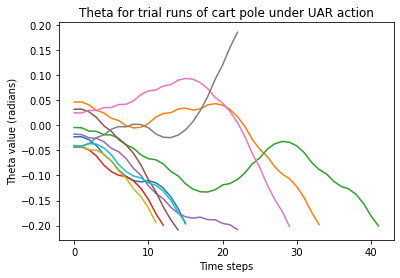

In [89]:
import numpy as np
import matplotlib.pyplot as plt

for i in range(10):
    plt.plot(theta_records[i])

#plt.plot(theta_records[0:5])
plt.title('Theta for trial runs of cart pole under UAR action')
plt.xlabel('Time steps')
plt.ylabel('Theta value (radians)')

In [142]:
# task 0: survive 10 steps (0/1)
# task 1: survive 20 steps (0/1)
# task 2: survive 30 steps (0/1)
# task 3: number of steps survived (numerical)
# task 4: avg of last 10 thetas
# task 5: avg of all thetas

performance = np.zeros([n_episodes, 6])

for i in range(n_episodes):
    performance[i,0] = len(theta_records[i]) >= 10
    performance[i,1] = len(theta_records[i]) >= 20
    performance[i,2] = len(theta_records[i]) >= 30
    performance[i,3] = len(theta_records[i])
    performance[i,4] = np.mean(np.array(theta_records[i][-min(len(theta_records[i]),10):]))
    performance[i,5] = np.mean(theta_records[i])

In [143]:
np.set_printoptions( linewidth=150)
performance

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.60000000e+01, -1.26908903e-01, -9.45945457e-02],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  3.40000000e+01, -1.06169920e-01, -1.45154223e-02],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  4.20000000e+01, -1.29649998e-01, -8.11143716e-02],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.30000000e+01, -1.19396946e-01, -1.02240994e-01],
       [ 1.00000000e+00,  1.00000000e+00,  0.00000000e+00,  2.30000000e+01, -1.86689251e-01, -1.19159177e-01],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.50000000e+01, -1.01474242e-01, -6.06323023e-02],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  3.00000000e+01, -7.23908817e-02,  1.44657293e-02],
       [ 1.00000000e+00,  1.00000000e+00,  0.00000000e+00,  2.30000000e+01,  5.94140594e-02,  1.61627372e-02],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.20000000e+01, -1.05018689e-01, -9.43396414e-02],
 

In [ ]:
# Next, we use the callback function in stable_baselines3 to output the rewards during training iterations.
# We change the environment so that it outputs information on performance on both the main task 
# and the subtasks.

In [25]:


from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common import logger
from stable_baselines3 import A2C, SAC, PPO, TD3

In [26]:
import os

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.results_plotter import load_results, ts2xy

In [73]:
__all__ = ["Monitor", "ResultsWriter", "get_monitor_files", "load_results"]

import csv
import json
import os
import time
from glob import glob
from typing import Dict, List, Optional, Tuple, Union

import gym
import numpy as np
import pandas

from stable_baselines3.common.type_aliases import GymObs, GymStepReturn


class Monitor(gym.Wrapper):
    """
    A monitor wrapper for Gym environments, it is used to know the episode reward, length, time and other data.

    :param env: The environment
    :param filename: the location to save a log file, can be None for no log
    :param allow_early_resets: allows the reset of the environment before it is done
    :param reset_keywords: extra keywords for the reset call,
        if extra parameters are needed at reset
    :param info_keywords: extra information to log, from the information return of env.step()
    """

    EXT = "monitor.csv"

    def __init__(
        self,
        env: gym.Env,
        filename: Optional[str] = None,
        allow_early_resets: bool = True,
        reset_keywords: Tuple[str, ...] = (),
        info_keywords: Tuple[str, ...] = (),
    ):
        super(Monitor, self).__init__(env=env)
        self.t_start = time.time()
        if filename is not None:
            self.results_writer = ResultsWriter(
                filename,
                header={"t_start": self.t_start, "env_id": env.spec and env.spec.id},
                extra_keys=reset_keywords + info_keywords,
            )
        else:
            self.results_writer = None
        self.reset_keywords = reset_keywords
        self.info_keywords = info_keywords
        self.allow_early_resets = allow_early_resets
        self.rewards = None
        self.subtask_rewards = []
        self.needs_reset = True
        self.episode_returns = []
        self.episode_lengths = []
        self.episode_times = []
        self.total_steps = 0
        self.current_reset_info = {}  # extra info about the current episode, that was passed in during reset()

    def reset(self, **kwargs) -> GymObs:
        """
        Calls the Gym environment reset. Can only be called if the environment is over, or if allow_early_resets is True

        :param kwargs: Extra keywords saved for the next episode. only if defined by reset_keywords
        :return: the first observation of the environment
        """
        
        print('reset')
        
        if not self.allow_early_resets and not self.needs_reset:
            raise RuntimeError(
                "Tried to reset an environment before done. If you want to allow early resets, "
                "wrap your env with Monitor(env, path, allow_early_resets=True)"
            )
        self.rewards = []
        self.subtask_rewards = []
        self.needs_reset = False
        print('reset keywords', self.reset_keywords)
        for key in self.reset_keywords:
            value = kwargs.get(key)
            if value is None:
                raise ValueError(f"Expected you to pass keyword argument {key} into reset")
            self.current_reset_info[key] = value
        return self.env.reset(**kwargs)


    def step(self, action: Union[np.ndarray, int]) -> GymStepReturn:
        """
        Step the environment with the given action

        :param action: the action
        :return: observation, reward, done, information
        """
        
        print('step')
        
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
        observation, reward, done, info = self.env.step(action)
        self.rewards.append(reward)
        self.subtask_rewards.append(info['subtask_1'])
        #self.subtask_rewards.append(list(info.values())[0])
        #print('current reward record', self.rewards)
        #print('current subtask reward record', self.subtask_rewards)
        print('episode subtask reward', info['subtask_1'])
        
        if done:
            self.needs_reset = True
        ep_rew = sum(self.rewards)
        ep_len = len(self.rewards)
        ep_subtask_rew = sum(self.subtask_rewards)
        ep_info = {"r": round(ep_rew, 6), "l": ep_len, "t": round(time.time() - self.t_start, 6), "sub_r": round(ep_subtask_rew, 6)}
        print('info_keywords', self.info_keywords)
        for key in self.info_keywords:
            ep_info[key] = info[key]
        self.episode_returns.append(ep_rew)
        self.episode_lengths.append(ep_len)
        self.episode_times.append(time.time() - self.t_start)
        ep_info.update(self.current_reset_info)
        if self.results_writer:
            self.results_writer.write_row(ep_info)
        info["episode"] = ep_info
        #print('ep_info', ep_info)
        self.total_steps += 1
        return observation, reward, done, info


    def close(self) -> None:
        """
        Closes the environment
        """
        super(Monitor, self).close()
        if self.results_writer is not None:
            self.results_writer.close()


    def get_total_steps(self) -> int:
        """
        Returns the total number of timesteps

        :return:
        """
        return self.total_steps


    def get_episode_rewards(self) -> List[float]:
        """
        Returns the rewards of all the episodes

        :return:
        """
        return self.episode_returns


    def get_episode_lengths(self) -> List[int]:
        """
        Returns the number of timesteps of all the episodes

        :return:
        """
        return self.episode_lengths


    def get_episode_times(self) -> List[float]:
        """
        Returns the runtime in seconds of all the episodes

        :return:
        """
        return self.episode_times



class LoadMonitorResultsError(Exception):
    """
    Raised when loading the monitor log fails.
    """

    pass


class ResultsWriter:
    """
    A result writer that saves the data from the `Monitor` class

    :param filename: the location to save a log file, can be None for no log
    :param header: the header dictionary object of the saved csv
    :param reset_keywords: the extra information to log, typically is composed of
        ``reset_keywords`` and ``info_keywords``
    """

    def __init__(
        self,
        filename: str = "",
        header: Dict[str, Union[float, str]] = None,
        extra_keys: Tuple[str, ...] = (),
    ):
        if header is None:
            header = {}
        if not filename.endswith(Monitor.EXT):
            if os.path.isdir(filename):
                filename = os.path.join(filename, Monitor.EXT)
            else:
                filename = filename + "." + Monitor.EXT
        self.file_handler = open(filename, "wt")
        self.file_handler.write("#%s\n" % json.dumps(header))
        self.logger = csv.DictWriter(self.file_handler, fieldnames=("r", "l", "t", "sub_r") + extra_keys)
        self.logger.writeheader()
        self.file_handler.flush()

    def write_row(self, epinfo: Dict[str, Union[float, int]]) -> None:
        """
        Close the file handler

        :param epinfo: the information on episodic return, length, and time
        """
        if self.logger:
            self.logger.writerow(epinfo)
            self.file_handler.flush()


    def close(self) -> None:
        """
        Close the file handler
        """
        self.file_handler.close()


def get_monitor_files(path: str) -> List[str]:
    """
    get all the monitor files in the given path

    :param path: the logging folder
    :return: the log files
    """
    return glob(os.path.join(path, "*" + Monitor.EXT))



def load_results(path: str) -> pandas.DataFrame:
    """
    Load all Monitor logs from a given directory path matching ``*monitor.csv``

    :param path: the directory path containing the log file(s)
    :return: the logged data
    """
    monitor_files = get_monitor_files(path)
    if len(monitor_files) == 0:
        raise LoadMonitorResultsError(f"No monitor files of the form *{Monitor.EXT} found in {path}")
    data_frames, headers = [], []
    for file_name in monitor_files:
        with open(file_name, "rt") as file_handler:
            first_line = file_handler.readline()
            assert first_line[0] == "#"
            header = json.loads(first_line[1:])
            data_frame = pandas.read_csv(file_handler, index_col=None)
            headers.append(header)
            data_frame["t"] += header["t_start"]
        data_frames.append(data_frame)
    data_frame = pandas.concat(data_frames)
    data_frame.sort_values("t", inplace=True)
    data_frame.reset_index(inplace=True)
    data_frame["t"] -= min(header["t_start"] for header in headers)
    return data_frame


In [63]:
# This is copied from stable_baselines3 tutorial

class SubtasksTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq, log_dir, verbose=1):
        super(SubtasksTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf
        self.logger = logger.Logger(log_dir, 'csv')

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            # IMPORTANT: evaluate here every x stsps
            print('loaded results', '\n', load_results(self.log_dir))
            
            #x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            #print('loaded results', x,y)
            '''
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print("Num timesteps: {}".format(self.num_timesteps))
                    print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print("Saving new best model at {} timesteps".format(x[-1]))
                        print("Saving new best model to {}.zip".format(self.save_path))
                    self.model.save(self.save_path)
            '''
        return True

In [119]:
from cartpole import CartPoleEnv
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

env1 = CartPoleEnv()

#eval_env = DummyVecEnv([lambda: env1])
eval_env = Monitor(env1, log_dir)

model = PPO('MlpPolicy', eval_env, verbose=0)
callback = SubtasksTrainingRewardCallback(check_freq=20, log_dir=log_dir, verbose=1)
model.learn(total_timesteps=1000, callback=callback)

reset
reset keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
reset
reset keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
loaded resul

step
episode subtask reward 0
info_keywords ()
reset
reset keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
loaded results 
     index           r   l             t     sub_r
0       0   36.741874   1  18081.730908  0.423996
1       1   74.240697   2  18081.734530  0.845419
2       2  112.470245   3  18081.737885  1.264584
3       3  149.146717   4  18081.740421  1.682748
4       4  181.985999   5  18081.743430  2.098659
..    ...         ...  ..           ...       ...
95     75    6.000000   6  64870.621936  6.000000
96     76    7.000000   7  64870.623141  7

step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
reset
reset keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
loaded results 
      index           r  l             t     sub_r
0        0   36.741874  1  18081.730908  0.423996
1        1   74.240697  2  18081.734530  0.845419
2        2  112.470245  3  18081.737885  1.264584
3        3  149.146717  4  18081.740421  1.682748
4        4  181.985999  5  18081.743430  2.098659
..     ...         ... ..           ...       ...
235    215    4.000000  4  64871.114583  4.000000
236    216    5.000000  5  64871.116170  5

step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
loaded results 
      index           r   l             t      sub_r
0        0   36.741874   1  18081.730908   0.423996
1        1   74.240697   2  18081.734530   0.845419
2        2  112.470245   3  18081.737885   1.264584
3        3  149.146717   4  18081.740421   1.682748
4        4  181.985999   5  18081.743430   2.098659
..     ...         ...  ..           ...        ...
355    335   30.000000  30  64871.512121  30.000000
356    336   31.000000  31  64871.513957  31.000000
357    337   32.000000  32  64871.515235  32.000000
358    338   33.000000  33  64871.516550  33.000000
359    339   34.000000  34  64871.5

step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
loaded results 
      index           r   l             t      sub_r
0        0   36.741874   1  18081.730908   0.423996
1        1   74.240697   2  18081.734530   0.845419
2        2  112.470245   3  18081.737885   1.264584
3        3  149.146717   4  18081.740421   1.682748
4        4  181.985999   5  18081.743430   2.098659
..     ...         ...  ..           ...        ...
475    455   19.000000  19  64871.920638  18.000000
476    456   20.000000  20  64871.922172  18.00000

loaded results 
      index           r  l             t     sub_r
0        0   36.741874  1  18081.730908  0.423996
1        1   74.240697  2  18081.734530  0.845419
2        2  112.470245  3  18081.737885  1.264584
3        3  149.146717  4  18081.740421  1.682748
4        4  181.985999  5  18081.743430  2.098659
..     ...         ... ..           ...       ...
635    615    3.000000  3  64872.301699  3.000000
636    616    4.000000  4  64872.302862  4.000000
637    617    5.000000  5  64872.304082  5.000000
638    618    6.000000  6  64872.305261  6.000000
639    619    7.000000  7  64872.306792  7.000000

[640 rows x 5 columns]
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
reset
reset keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
e

step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
loaded results 
      index           r   l             t      sub_r
0        0   36.741874   1  18081.730908   0.423996
1        1   74.240697   2  18081.734530   0.845419
2        2  112.470245   3  18081.737885   1.264584
3        3  149.146717   4  18081.740421   1.682748
4        4  181.985999   5  18081.743430   2.098659
..     ...         ...  ..           ...        ...
835    815    7.000000   7  64872.750136   7.000000
836    816    8.000000   8  64872.751332   8.000000
837    817    9.000000   9  64872.752632   9.000000
838    818   10.000000  10  64872.753848  10.000000
839    819   11.000000  11  64872.7

step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
loaded results 
       index           r   l             t      sub_r
0         0   36.741874   1  18081.730908   0.423996
1         1   74.240697   2  18081.734530   0.845419
2         2  112.470245   3  18081.737885   1.264584
3         3  149.146717   4  18081.740421   1.682748
4         4  181.985999   5  18081.743430   2.098659
...    

step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
reset
reset keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
loaded results 
       index           r   l             t      sub_r
0         0   36.741874   1  18081.730908   0.423996
1      

loaded results 
       index           r   l             t      sub_r
0         0   36.741874   1  18081.730908   0.423996
1         1   74.240697   2  18081.734530   0.845419
2         2  112.470245   3  18081.737885   1.264584
3         3  149.146717   4  18081.740421   1.682748
4         4  181.985999   5  18081.743430   2.098659
...     ...         ...  ..           ...        ...
1375   1355   40.000000  40  64873.957453  40.000000
1376   1356   41.000000  41  64873.958628  41.000000
1377   1357   42.000000  42  64873.959950  42.000000
1378   1358   43.000000  43  64873.961192  42.000000
1379   1359   44.000000  44  64873.962447  42.000000

[1380 rows x 5 columns]
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
reset
reset keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode sub

step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
loaded results 
       index           r   l             t  

loaded results 
       index           r   l             t     sub_r
0         0   36.741874   1  18081.730908  0.423996
1         1   74.240697   2  18081.734530  0.845419
2         2  112.470245   3  18081.737885  1.264584
3         3  149.146717   4  18081.740421  1.682748
4         4  181.985999   5  18081.743430  2.098659
...     ...         ...  ..           ...       ...
1755   1735   14.000000  14  64874.778205  9.000000
1756   1736   15.000000  15  64874.779377  9.000000
1757   1737    1.000000   1  64874.781229  1.000000
1758   1738    2.000000   2  64874.782574  2.000000
1759   1739    3.000000   3  64874.784108  3.000000

[1760 rows x 5 columns]
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step


loaded results 
       index           r   l             t     sub_r
0         0   36.741874   1  18081.730908  0.423996
1         1   74.240697   2  18081.734530  0.845419
2         2  112.470245   3  18081.737885  1.264584
3         3  149.146717   4  18081.740421  1.682748
4         4  181.985999   5  18081.743430  2.098659
...     ...         ...  ..           ...       ...
1955   1935    6.000000   6  64875.210778  6.000000
1956   1936    7.000000   7  64875.211992  7.000000
1957   1937    8.000000   8  64875.213306  7.000000
1958   1938    9.000000   9  64875.214491  7.000000
1959   1939   10.000000  10  64875.215749  7.000000

[1960 rows x 5 columns]
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
step
episode subtask reward 0
info_keywords ()
reset
reset keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 1
info_keywords ()
step
episode subtask reward 

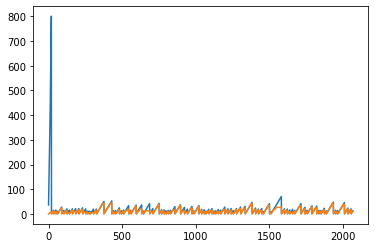

In [120]:
df = load_results(log_dir)
plt.plot(df['r'])
plt.plot(df['sub_r'])

In [3]:
import os, sys

module_path = os.path.abspath(os.path.join('.'))
# if module_path not in sys.path:
sys.path.append(module_path + "/gym/gym/envs/classic_control")
print('{}'.format(sys.path))

['/Users/yujiazhang', '/Users/yujiazhang/opt/anaconda3/lib/python38.zip', '/Users/yujiazhang/opt/anaconda3/lib/python3.8', '/Users/yujiazhang/opt/anaconda3/lib/python3.8/lib-dynload', '', '/Users/yujiazhang/opt/anaconda3/lib/python3.8/site-packages', '/Users/yujiazhang/opt/anaconda3/lib/python3.8/site-packages/aeosa', '/Users/yujiazhang/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions', '/Users/yujiazhang/.ipython', '/Users/yujiazhang/gym/gym/envs/classic_control']


In [35]:
def get_cumulative_reward(r):
    r_cum = r
    for i in range(1,len(r)):
        r_cum[i] = r[i] + r[i-1]
    
    return r_cum
    

Text(0, 0.5, 'Cumulative reward')

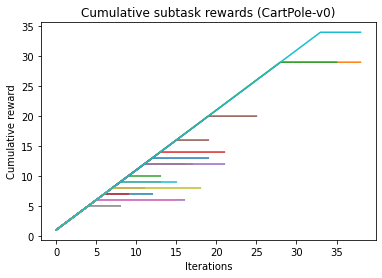

In [37]:

for i in range(n_episodes):
    cumulative_subtask_rewards = get_cumulative_reward(subtask_records[i])
    plt.plot(cumulative_subtask_rewards)

#plt.plot(theta_records[0:5])
plt.title('Cumulative subtask rewards (CartPole-v0)')
plt.xlabel('Iterations')
plt.ylabel('Cumulative reward')

From the plot, we can see the following: If you die on the main task, you will fail the subtask a few steps earlier; in other words, the subtask serves as an early warning


In [36]:
# Next, try more complicated examples in mujuco
import mujoco_py

module_path = os.path.abspath(os.path.join('.'))
# if module_path not in sys.path:
sys.path.append(module_path + "/gym/gym/envs/mujoco")


In [54]:
from humanoidstandup import HumanoidStandupEnv

In [124]:
log_dir_humanoid = "/tmp/gym/humanoid"
os.makedirs(log_dir_humanoid, exist_ok=True)

env2 = HumanoidStandupEnv()

#eval_env = DummyVecEnv([lambda: env1])
eval_env2 = Monitor(env2, log_dir_humanoid)

model2 = A2C('MlpPolicy', eval_env2, verbose=0)
callback = SubtasksTrainingRewardCallback(check_freq=20, log_dir=log_dir_humanoid, verbose=1)
model2.learn(total_timesteps=10000, callback=callback)

37.0896817119707
reset
reset keywords ()
step
38.42010112721181
episode subtask reward 0.42639964195003965
info_keywords ()
step
41.32301504195641
episode subtask reward 0.4242209547987723
info_keywords ()
step
45.285652220074404
episode subtask reward 0.4217508261476803
info_keywords ()
step
50.31596750999957
episode subtask reward 0.4206796799949147
info_keywords ()
step
55.47731788129405
episode subtask reward 0.42072463723472225
info_keywords ()
step
59.56109385582565
episode subtask reward 0.420321673301365
info_keywords ()
step
62.226080549260814
episode subtask reward 0.4197196523461787
info_keywords ()
step
64.12779248162066
episode subtask reward 0.41893010632160804
info_keywords ()
step
65.52321518508924
episode subtask reward 0.4181360106982911
info_keywords ()
step
66.64446188620802
episode subtask reward 0.41734533741381796
info_keywords ()
step
66.7817110032992
episode subtask reward 0.4168896039324712
info_keywords ()
step
64.99282714087047
episode subtask reward 0.41707

step
26.66288921472514
episode subtask reward 0.3108114684069147
info_keywords ()
step
27.554101274332236
episode subtask reward 0.31262554928446357
info_keywords ()
step
29.483759640086745
episode subtask reward 0.3145808719322161
info_keywords ()
step
30.78156992999489
episode subtask reward 0.3170402750497724
info_keywords ()
step
32.35876105354531
episode subtask reward 0.32139678821389744
info_keywords ()
step
34.03889419460846
episode subtask reward 0.32625361593033153
info_keywords ()
step
35.911903209921036
episode subtask reward 0.33325743213889597
info_keywords ()
step
37.11616948389702
episode subtask reward 0.34176133996356933
info_keywords ()
step
36.512326752152255
episode subtask reward 0.34958832916963806
info_keywords ()
loaded results 
     index            r    l         t      sub_r
0       0    38.420101    1  0.008841   0.426400
1       1    79.743116    2  0.012075   0.850621
2       2   125.028768    3  0.015073   1.272371
3       3   175.344736    4  0.017798  

step
29.98883280142608
episode subtask reward 0.5080206161520567
info_keywords ()
step
30.610580061491984
episode subtask reward 0.5116155209304948
info_keywords ()
loaded results 
      index            r    l         t      sub_r
0        0    38.420101    1  0.008841   0.426400
1        1    79.743116    2  0.012075   0.850621
2        2   125.028768    3  0.015073   1.272371
3        3   175.344736    4  0.017798   1.693051
4        4   230.822054    5  0.021403   2.113776
..     ...          ...  ...       ...        ...
215    215  7886.977576  216  0.801688  93.564893
216    216  7915.905767  217  0.804726  94.065696
217    217  7945.589232  218  0.807077  94.570109
218    218  7975.578065  219  0.809866  95.078130
219    219  8006.188645  220  0.812142  95.589746

[220 rows x 5 columns]
step
30.31926937132306
episode subtask reward 0.5152215695273857
info_keywords ()
step
27.075810349236153
episode subtask reward 0.5185537957251217
info_keywords ()
step
25.592921425448086
episo

step
39.00265200032438
episode subtask reward 0.3948266917631953
info_keywords ()
step
42.57288911103191
episode subtask reward 0.3912959151162077
info_keywords ()
step
45.809348138210815
episode subtask reward 0.3867207182908546
info_keywords ()
step
47.70349059968638
episode subtask reward 0.3821338131707176
info_keywords ()
step
48.49338871900355
episode subtask reward 0.37755625864258646
info_keywords ()
step
48.688594023454314
episode subtask reward 0.3731993990615102
info_keywords ()
step
48.99126716141951
episode subtask reward 0.3698788533804053
info_keywords ()
step
49.22318743628781
episode subtask reward 0.36734874017618163
info_keywords ()
step
49.87353874989361
episode subtask reward 0.36490520494689654
info_keywords ()
step
49.99632858078351
episode subtask reward 0.3623695231316325
info_keywords ()
step
49.087340520027645
episode subtask reward 0.35987045746253277
info_keywords ()
step
49.13339274049953
episode subtask reward 0.35745716727606475
info_keywords ()
step
49.

step
49.580595892368606
episode subtask reward 0.1996157250835942
info_keywords ()
step
49.0245932404658
episode subtask reward 0.20031042036545452
info_keywords ()
step
49.64107576317479
episode subtask reward 0.20040054545513714
info_keywords ()
step
50.45377266965165
episode subtask reward 0.20071272009978386
info_keywords ()
step
51.082869613849375
episode subtask reward 0.2012215018193864
info_keywords ()
step
51.07040110271931
episode subtask reward 0.20179206185828108
info_keywords ()
step
50.81543836766772
episode subtask reward 0.2028768293774507
info_keywords ()
step
50.1307471065518
episode subtask reward 0.20395009008709317
info_keywords ()
step
49.18570787548947
episode subtask reward 0.20341407251486945
info_keywords ()
step
47.07031771661229
episode subtask reward 0.20170786586427406
info_keywords ()
step
45.45542487207692
episode subtask reward 0.1993321417199041
info_keywords ()
step
47.12611190614031
episode subtask reward 0.19739676738853904
info_keywords ()
step
49.

step
42.85966023892597
episode subtask reward 0.21706768848473643
info_keywords ()
step
41.2965662415026
episode subtask reward 0.21717262832557876
info_keywords ()
step
38.98222068752589
episode subtask reward 0.21727682167973109
info_keywords ()
step
34.87680185882603
episode subtask reward 0.2178145328434923
info_keywords ()
step
30.444254682036867
episode subtask reward 0.2185801896073798
info_keywords ()
step
29.040842778169804
episode subtask reward 0.21833936469827916
info_keywords ()
step
28.626570915072637
episode subtask reward 0.2161125483746386
info_keywords ()
step
29.982157006997326
episode subtask reward 0.21303863710049994
info_keywords ()
step
31.009662338090166
episode subtask reward 0.20943077710978433
info_keywords ()
step
32.04332656599277
episode subtask reward 0.20549363839036677
info_keywords ()
step
33.55634619189759
episode subtask reward 0.20082533980899053
info_keywords ()
step
34.965181187071494
episode subtask reward 0.19678515844228528
info_keywords ()
lo

step
31.919336162517126
episode subtask reward -0.04314938935432837
info_keywords ()
step
33.54178343356257
episode subtask reward -0.040789242235776395
info_keywords ()
step
34.46079816992392
episode subtask reward -0.03695095627129628
info_keywords ()
step
35.78857886159487
episode subtask reward -0.032658539643110364
info_keywords ()
step
36.58083496409459
episode subtask reward -0.02952022010544861
info_keywords ()
step
34.70732945799474
episode subtask reward -0.026403923533446543
info_keywords ()
step
31.84404485136322
episode subtask reward -0.023260595986944764
info_keywords ()
step
29.307778813933325
episode subtask reward -0.021148261254556093
info_keywords ()
step
30.49891100625569
episode subtask reward -0.019909793643180376
info_keywords ()
step
33.57182569593687
episode subtask reward -0.018573645312479993
info_keywords ()
loaded results 
      index             r    l         t       sub_r
0        0     38.420101    1  0.008841    0.426400
1        1     79.743116    2 

30.45079286453476
episode subtask reward 0.2565849577623661
info_keywords ()
step
29.543087666704572
episode subtask reward 0.25663039992924086
info_keywords ()
step
27.96625168924176
episode subtask reward 0.2566441132766315
info_keywords ()
step
26.180187061977747
episode subtask reward 0.25769095697488814
info_keywords ()
step
26.014189966454992
episode subtask reward 0.258814058929213
info_keywords ()
step
26.4622001519056
episode subtask reward 0.2599698769625058
info_keywords ()
step
26.73710883859343
episode subtask reward 0.26183778448176004
info_keywords ()
step
26.364409473527488
episode subtask reward 0.26350916946985703
info_keywords ()
step
27.787680233856467
episode subtask reward 0.2661587925781263
info_keywords ()
step
28.871230111524675
episode subtask reward 0.269920773165686
info_keywords ()
step
30.30910357241822
episode subtask reward 0.27319272131241246
info_keywords ()
step
33.337364184034584
episode subtask reward 0.2754694311613022
info_keywords ()
step
36.4700

step
25.550034455554066
episode subtask reward 0.7861227532043645
info_keywords ()
step
28.249103541276803
episode subtask reward 0.7862543917122978
info_keywords ()
step
30.80310169121898
episode subtask reward 0.786872925848903
info_keywords ()
step
32.05314923866044
episode subtask reward 0.7876536093765708
info_keywords ()
step
31.8466788643356
episode subtask reward 0.7883801701745482
info_keywords ()
step
31.971805136351755
episode subtask reward 0.7889204735652963
info_keywords ()
step
33.72075073812298
episode subtask reward 0.7892814489849755
info_keywords ()
step
35.326022971649344
episode subtask reward 0.7892538759965574
info_keywords ()
step
35.971324508974696
episode subtask reward 0.7899241722253295
info_keywords ()
step
37.04190708698635
episode subtask reward 0.7914372637458664
info_keywords ()
step
37.490681526904815
episode subtask reward 0.7926886251238061
info_keywords ()
step
37.24560267062707
episode subtask reward 0.7938478507596032
info_keywords ()
loaded resul

step
27.11382481887406
episode subtask reward 0.7296545345120296
info_keywords ()
step
29.607485905408158
episode subtask reward 0.729314648318718
info_keywords ()
step
31.96235675100546
episode subtask reward 0.7288095293831224
info_keywords ()
step
34.70775078039535
episode subtask reward 0.7283150160289892
info_keywords ()
step
37.30764379654034
episode subtask reward 0.7276714451569966
info_keywords ()
step
39.66106787442395
episode subtask reward 0.7270478953842661
info_keywords ()
step
42.07415945977503
episode subtask reward 0.7283045082814263
info_keywords ()
step
44.01209710426511
episode subtask reward 0.7316224014918109
info_keywords ()
step
45.200419238457705
episode subtask reward 0.7352285884857142
info_keywords ()
step
45.58032688113707
episode subtask reward 0.7386333281574282
info_keywords ()
step
45.33833174320223
episode subtask reward 0.7419947571013515
info_keywords ()
step
44.834963897513916
episode subtask reward 0.7450061909472537
info_keywords ()
step
43.746725

[1180 rows x 5 columns]
step
54.223908761884275
episode subtask reward 0.5932134675987042
info_keywords ()
step
56.783023030284205
episode subtask reward 0.5862336158799237
info_keywords ()
step
58.21634809315861
episode subtask reward 0.5791766779571863
info_keywords ()
step
58.55549600250686
episode subtask reward 0.572060909746284
info_keywords ()
step
59.27832645916426
episode subtask reward 0.5646534749412432
info_keywords ()
step
60.88737394961339
episode subtask reward 0.5574456884821837
info_keywords ()
step
62.52963063767336
episode subtask reward 0.5506924757011012
info_keywords ()
step
63.16297869258466
episode subtask reward 0.5439270456794435
info_keywords ()
step
63.15240093020102
episode subtask reward 0.5371517688510479
info_keywords ()
step
63.442045996391606
episode subtask reward 0.5308226028771732
info_keywords ()
step
63.45203765271469
episode subtask reward 0.5245760376448345
info_keywords ()
step
62.70111406628565
episode subtask reward 0.5181710767327377
info_ke

step
45.57404798709221
episode subtask reward 0.4370467188364074
info_keywords ()
step
46.81366831559907
episode subtask reward 0.42963144907772366
info_keywords ()
step
47.97214454534734
episode subtask reward 0.42242246226158586
info_keywords ()
step
47.65722335590334
episode subtask reward 0.4151452457084292
info_keywords ()
loaded results 
       index             r     l         t       sub_r
0         0     38.420101     1  0.008841    0.426400
1         1     79.743116     2  0.012075    0.850621
2         2    125.028768     3  0.015073    1.272371
3         3    175.344736     4  0.017798    1.693051
4         4    230.822054     5  0.021403    2.113776
...     ...           ...   ...       ...         ...
1295   1295  48836.923437  1296  4.469908  528.170955
1296   1296  48882.497485  1297  4.472767  528.608002
1297   1297  48929.311154  1298  4.475537  529.037633
1298   1298  48977.283298  1299  4.477944  529.460055
1299   1299  49024.940522  1300  4.480190  529.875201

[130

step
26.885563911114875
episode subtask reward 0.4672583171420473
info_keywords ()
step
27.003430527770277
episode subtask reward 0.4700571270143035
info_keywords ()
step
26.574801336948735
episode subtask reward 0.4722529649042889
info_keywords ()
step
26.09114890229803
episode subtask reward 0.4730645341012545
info_keywords ()
step
25.862931915625254
episode subtask reward 0.4723452420622142
info_keywords ()
step
26.335802771634064
episode subtask reward 0.46832856621188196
info_keywords ()
step
28.14376753320396
episode subtask reward 0.4632042448875938
info_keywords ()
step
30.138681867101997
episode subtask reward 0.4580857977896457
info_keywords ()
step
31.41612322228861
episode subtask reward 0.4531023455656559
info_keywords ()
step
32.15899310352498
episode subtask reward 0.44971810034120435
info_keywords ()
loaded results 
       index             r     l         t       sub_r
0         0     38.420101     1  0.008841    0.426400
1         1     79.743116     2  0.012075    0.

step
51.44335996520266
episode subtask reward 0.5567813687569152
info_keywords ()
step
51.723755412492125
episode subtask reward 0.56089317398453
info_keywords ()
step
53.054173072517365
episode subtask reward 0.5667340345243472
info_keywords ()
step
53.61518493535584
episode subtask reward 0.5735451974721926
info_keywords ()
step
53.94594098919334
episode subtask reward 0.5806923369937899
info_keywords ()
step
53.963745836493345
episode subtask reward 0.5878454552964927
info_keywords ()
step
52.31544380370646
episode subtask reward 0.594985634063358
info_keywords ()
step
50.162614463017675
episode subtask reward 0.602121650751292
info_keywords ()
step
47.24741371218973
episode subtask reward 0.609278855386769
info_keywords ()
step
43.57502709017761
episode subtask reward 0.615363632206611
info_keywords ()
step
38.890958099735734
episode subtask reward 0.620346065057411
info_keywords ()
step
34.83841083645436
episode subtask reward 0.6242412540421503
info_keywords ()
step
33.9485225174

[1640 rows x 5 columns]
step
38.09458994001921
episode subtask reward 0.8960202543675406
info_keywords ()
step
37.89852977549495
episode subtask reward 0.897390028815279
info_keywords ()
step
37.56808931626688
episode subtask reward 0.8984912490916788
info_keywords ()
step
39.17242427896862
episode subtask reward 0.8988330996027323
info_keywords ()
step
40.498689580001
episode subtask reward 0.8990629324507091
info_keywords ()
step
41.09364387354852
episode subtask reward 0.8993057509159943
info_keywords ()
step
40.71252438837264
episode subtask reward 0.899538937525801
info_keywords ()
step
39.14669793120615
episode subtask reward 0.8998896807701089
info_keywords ()
step
36.72207433151623
episode subtask reward 0.8991316808978258
info_keywords ()
step
34.23074761464863
episode subtask reward 0.8969076200483355
info_keywords ()
step
30.862690379103373
episode subtask reward 0.8953561063056856
info_keywords ()
step
31.874495772222115
episode subtask reward 0.8952278482878259
info_keywor

step
28.84160914889882
episode subtask reward 0.690105251146931
info_keywords ()
step
28.813475501832084
episode subtask reward 0.6883753439515534
info_keywords ()
step
27.51774215781652
episode subtask reward 0.6866417173765215
info_keywords ()
step
26.885654953149405
episode subtask reward 0.6848615000540322
info_keywords ()
step
27.220973077690804
episode subtask reward 0.6825083684258457
info_keywords ()
loaded results 
       index             r     l         t       sub_r
0         0     38.420101     1  0.008841    0.426400
1         1     79.743116     2  0.012075    0.850621
2         2    125.028768     3  0.015073    1.272371
3         3    175.344736     4  0.017798    1.693051
4         4    230.822054     5  0.021403    2.113776
...     ...           ...   ...       ...         ...
1755   1755  65998.761811  1756  6.104116  810.119230
1756   1756  66027.575287  1757  6.106369  810.807605
1757   1757  66055.093029  1758  6.108892  811.494247
1758   1758  66081.978684  1759

step
29.351567318558526
episode subtask reward 0.6406058654269263
info_keywords ()
step
27.790544679840753
episode subtask reward 0.6386924954231162
info_keywords ()
step
28.40197503379776
episode subtask reward 0.6357403022053887
info_keywords ()
step
31.518634534522388
episode subtask reward 0.6322539040371824
info_keywords ()
step
34.259410298632766
episode subtask reward 0.6287974573710912
info_keywords ()
step
36.45852889796636
episode subtask reward 0.6254007791512028
info_keywords ()
step
37.852877669905126
episode subtask reward 0.6219901522049809
info_keywords ()
step
37.80253936433742
episode subtask reward 0.6185691530679315
info_keywords ()
step
36.50272474298628
episode subtask reward 0.6160311579068243
info_keywords ()
loaded results 
       index             r     l         t       sub_r
0         0     38.420101     1  0.008841    0.426400
1         1     79.743116     2  0.012075    0.850621
2         2    125.028768     3  0.015073    1.272371
3         3    175.34473

step
40.003537274460236
episode subtask reward 0.24695795321761085
info_keywords ()
step
41.3884009072286
episode subtask reward 0.23461052668694113
info_keywords ()
step
41.91779423031758
episode subtask reward 0.2225615984127878
info_keywords ()
step
43.18323768127155
episode subtask reward 0.21118827884434402
info_keywords ()
step
44.43155716319526
episode subtask reward 0.1999919752387944
info_keywords ()
step
45.5044828800983
episode subtask reward 0.18907842363848779
info_keywords ()
step
45.48237693921089
episode subtask reward 0.17828312237220806
info_keywords ()
step
46.10945983404037
episode subtask reward 0.16750033335326983
info_keywords ()
step
46.08339754179674
episode subtask reward 0.15729244652683025
info_keywords ()
step
45.415430602231794
episode subtask reward 0.14754277969495824
info_keywords ()
step
44.49699171305832
episode subtask reward 0.1380212459584225
info_keywords ()
step
43.57485098348532
episode subtask reward 0.12949475852564782
info_keywords ()
step
43

step
50.32089433197224
episode subtask reward -0.008287841748427652
info_keywords ()
step
52.43259343111008
episode subtask reward -0.010595274108706377
info_keywords ()
step
53.96543207558417
episode subtask reward -0.011471478349550765
info_keywords ()
step
54.5522245883973
episode subtask reward -0.011748035040551325
info_keywords ()
loaded results 
       index             r     l         t       sub_r
0         0     38.420101     1  0.008841    0.426400
1         1     79.743116     2  0.012075    0.850621
2         2    125.028768     3  0.015073    1.272371
3         3    175.344736     4  0.017798    1.693051
4         4    230.822054     5  0.021403    2.113776
...     ...           ...   ...       ...         ...
2095   2095  79179.719460  2096  7.318208  950.690621
2096   2096  79230.040354  2097  7.321405  950.682333
2097   2097  79282.472947  2098  7.324189  950.671738
2098   2098  79336.438379  2099  7.326875  950.660267
2099   2099  79390.990604  2100  7.329363  950.648

step
63.27325125308319
episode subtask reward -0.37090304326763357
info_keywords ()
step
62.81343995644493
episode subtask reward -0.3672194861745832
info_keywords ()
step
61.05929724446539
episode subtask reward -0.3640505276321962
info_keywords ()
step
58.72950045528212
episode subtask reward -0.3630978165947015
info_keywords ()
step
56.0134492001544
episode subtask reward -0.36264425150684465
info_keywords ()
step
53.30812925651623
episode subtask reward -0.36235092120218326
info_keywords ()
step
50.12701426269733
episode subtask reward -0.3621601837430824
info_keywords ()
step
46.188670718191545
episode subtask reward -0.3619794178997683
info_keywords ()
step
42.7311616002834
episode subtask reward -0.36215319907103777
info_keywords ()
step
39.8356259411492
episode subtask reward -0.36340306671722244
info_keywords ()
step
38.657519663749696
episode subtask reward -0.36810868783242723
info_keywords ()
step
38.60596614308572
episode subtask reward -0.3734875139214413
info_keywords ()

loaded results 
       index             r     l         t       sub_r
0         0     38.420101     1  0.008841    0.426400
1         1     79.743116     2  0.012075    0.850621
2         2    125.028768     3  0.015073    1.272371
3         3    175.344736     4  0.017798    1.693051
4         4    230.822054     5  0.021403    2.113776
...     ...           ...   ...       ...         ...
2315   2315  89318.952816  2316  8.117428  893.292223
2316   2316  89369.955456  2317  8.120392  893.122429
2317   2317  89422.262526  2318  8.122592  892.955012
2318   2318  89475.178403  2319  8.124913  892.790338
2319   2319  89528.775882  2320  8.127448  892.628963

[2320 rows x 5 columns]
step
53.528157667618366
episode subtask reward -0.15772063177514264
info_keywords ()
step
52.287815713019484
episode subtask reward -0.15429783099067676
info_keywords ()
step
50.72113733144383
episode subtask reward -0.15070077885213265
info_keywords ()
step
49.44812622484548
episode subtask reward -0.1473905

step
81.22364474688881
episode subtask reward 0.17044858095346094
info_keywords ()
step
77.59747050295934
episode subtask reward 0.17146310111699406
info_keywords ()
step
73.42450682013585
episode subtask reward 0.17112881512914963
info_keywords ()
step
68.99170606665344
episode subtask reward 0.1707650820415212
info_keywords ()
step
67.1599783675824
episode subtask reward 0.16941262104052116
info_keywords ()
step
67.42027715457557
episode subtask reward 0.16638539497194768
info_keywords ()
step
68.01376393074565
episode subtask reward 0.16190500734867683
info_keywords ()
step
68.38198362249493
episode subtask reward 0.15629200323723094
info_keywords ()
step
67.99585540347391
episode subtask reward 0.15070017368843594
info_keywords ()
loaded results 
       index             r     l         t       sub_r
0         0     38.420101     1  0.008841    0.426400
1         1     79.743116     2  0.012075    0.850621
2         2    125.028768     3  0.015073    1.272371
3         3    175.344

step
51.75185462292166
episode subtask reward -0.030827845135798195
info_keywords ()
step
48.28522417014303
episode subtask reward -0.03624269722424182
info_keywords ()
step
44.61077866527123
episode subtask reward -0.04164547451633117
info_keywords ()
step
40.68309549898044
episode subtask reward -0.04705409473379264
info_keywords ()
step
38.6439740254511
episode subtask reward -0.0525335378709789
info_keywords ()
loaded results 
       index              r     l         t       sub_r
0         0      38.420101     1  0.008841    0.426400
1         1      79.743116     2  0.012075    0.850621
2         2     125.028768     3  0.015073    1.272371
3         3     175.344736     4  0.017798    1.693051
4         4     230.822054     5  0.021403    2.113776
...     ...            ...   ...       ...         ...
2535   2535  101960.627738  2536  8.952802  895.148900
2536   2536  102008.912962  2537  8.955118  895.112657
2537   2537  102053.523740  2538  8.957500  895.071011
2538   2538  1

step
33.97771939922475
episode subtask reward -0.06660293729348138
info_keywords ()
step
34.16080033213576
episode subtask reward -0.0632525929311989
info_keywords ()
step
33.99743441499214
episode subtask reward -0.060354504664171145
info_keywords ()
step
33.50922177428822
episode subtask reward -0.059362688674481585
info_keywords ()
step
32.31626497690139
episode subtask reward -0.05914733327287398
info_keywords ()
step
30.891483597845305
episode subtask reward -0.058679208438317705
info_keywords ()
step
29.589872618207647
episode subtask reward -0.05873945100809445
info_keywords ()
step
29.3114832646222
episode subtask reward -0.05801115311510186
info_keywords ()
step
31.409895207500167
episode subtask reward -0.05542758573803129
info_keywords ()
step
34.115536641467926
episode subtask reward -0.05193269194750613
info_keywords ()
step
35.25570079023791
episode subtask reward -0.04829972854936057
info_keywords ()
step
38.12187716850308
episode subtask reward -0.044685445228371645
inf

step
43.0252605631765
episode subtask reward -0.07084476020841052
info_keywords ()
step
43.530187272183774
episode subtask reward -0.06932377409296603
info_keywords ()
step
43.04529035856301
episode subtask reward -0.06579708658378211
info_keywords ()
loaded results 
       index              r     l         t       sub_r
0         0      38.420101     1  0.008841    0.426400
1         1      79.743116     2  0.012075    0.850621
2         2     125.028768     3  0.015073    1.272371
3         3     175.344736     4  0.017798    1.693051
4         4     230.822054     5  0.021403    2.113776
...     ...            ...   ...       ...         ...
2755   2755  111353.084485  2756  9.762286  884.750190
2756   2756  111395.130188  2757  9.764655  884.677916
2757   2757  111438.155449  2758  9.767575  884.607071
2758   2758  111481.685636  2759  9.770425  884.537747
2759   2759  111524.730926  2760  9.772667  884.471950

[2760 rows x 5 columns]
step
41.424093571905495
episode subtask reward

step
32.60147351851839
episode subtask reward -0.012856243212201518
info_keywords ()
step
33.75365741029435
episode subtask reward -0.013037655025077319
info_keywords ()
step
34.99590563966417
episode subtask reward -0.013218642077658714
info_keywords ()
step
36.4136658986975
episode subtask reward -0.013396339748932532
info_keywords ()
step
37.284446085029394
episode subtask reward -0.013574534399260567
info_keywords ()
step
35.45406226902174
episode subtask reward -0.013758124012519446
info_keywords ()
step
31.58146251496658
episode subtask reward -0.013898650001204224
info_keywords ()
step
27.18154230443027
episode subtask reward -0.013937520136345269
info_keywords ()
step
25.331797203650964
episode subtask reward -0.012307557330943502
info_keywords ()
step
25.08709951116937
episode subtask reward -0.008538902731728954
info_keywords ()
step
25.047258015381516
episode subtask reward -0.0029710972601641288
info_keywords ()
step
25.243342064649973
episode subtask reward 0.0037938618224

step
41.73997431082155
episode subtask reward 0.24486889861932085
info_keywords ()
step
42.37297079451916
episode subtask reward 0.24541966251497271
info_keywords ()
step
42.82214502546323
episode subtask reward 0.24675842075507684
info_keywords ()
step
43.69150160753674
episode subtask reward 0.24639040253605568
info_keywords ()
step
46.20585136664996
episode subtask reward 0.24259997390592106
info_keywords ()
step
47.79723788505187
episode subtask reward 0.23729193791370232
info_keywords ()
step
48.946869960795695
episode subtask reward 0.23251325879826104
info_keywords ()
step
51.153188310899694
episode subtask reward 0.2276333015796577
info_keywords ()
step
53.3898990332992
episode subtask reward 0.22272965028551914
info_keywords ()
step
56.16478484325033
episode subtask reward 0.21779764264380586
info_keywords ()
loaded results 
       index              r     l          t       sub_r
0         0      38.420101     1   0.008841    0.426400
1         1      79.743116     2   0.0120

step
64.81460476840078
episode subtask reward -0.1439427477013644
info_keywords ()
step
62.590556497671685
episode subtask reward -0.14820228226851617
info_keywords ()
step
60.8854167227183
episode subtask reward -0.1525820479319796
info_keywords ()
step
59.89129917271144
episode subtask reward -0.15825368505427992
info_keywords ()
step
59.85156905615172
episode subtask reward -0.16333758886079336
info_keywords ()
step
59.18268654670239
episode subtask reward -0.16829000692175056
info_keywords ()
step
57.82429678289896
episode subtask reward -0.1735132513051619
info_keywords ()
step
56.30097062694072
episode subtask reward -0.17897025806184597
info_keywords ()
step
55.342102746761796
episode subtask reward -0.1838531077045206
info_keywords ()
step
55.744292589139285
episode subtask reward -0.18798739264378392
info_keywords ()
step
55.99220605231986
episode subtask reward -0.19282966780592145
info_keywords ()
loaded results 
       index              r     l          t       sub_r
0    

step
30.03029853396743
episode subtask reward -0.4053774177983626
info_keywords ()
loaded results 
       index              r     l          t       sub_r
0         0      38.420101     1   0.008841    0.426400
1         1      79.743116     2   0.012075    0.850621
2         2     125.028768     3   0.015073    1.272371
3         3     175.344736     4   0.017798    1.693051
4         4     230.822054     5   0.021403    2.113776
...     ...            ...   ...        ...         ...
3175   3175  129261.200326  3176  11.380581  861.624008
3176   3176  129297.990811  3177  11.382854  861.237591
3177   3177  129333.080355  3178  11.385311  860.844631
3178   3178  129365.550136  3179  11.387865  860.445321
3179   3179  129395.580434  3180  11.391033  860.039943

[3180 rows x 5 columns]
step
29.96729745039748
episode subtask reward -0.41113329953247657
info_keywords ()
step
30.23661580876691
episode subtask reward -0.41635181892034384
info_keywords ()
step
28.024219050673153
episode sub

step
28.85494859133074
episode subtask reward -0.4846242571847023
info_keywords ()
step
27.43836539152512
episode subtask reward -0.48569215130249305
info_keywords ()
step
24.962516908829034
episode subtask reward -0.48676529139283625
info_keywords ()
step
24.83487238490404
episode subtask reward -0.4877966077334349
info_keywords ()
step
27.6627199818294
episode subtask reward -0.4895301478963667
info_keywords ()
step
32.7861529305092
episode subtask reward -0.49160165371362885
info_keywords ()
step
37.855090595635126
episode subtask reward -0.4936684598580665
info_keywords ()
step
41.09709094343061
episode subtask reward -0.49570570150717047
info_keywords ()
step
41.963427562673814
episode subtask reward -0.4977537323497883
info_keywords ()
step
40.94410239948637
episode subtask reward -0.4997831014330935
info_keywords ()
step
39.337273965437674
episode subtask reward -0.501901468685732
info_keywords ()
step
38.572930387555154
episode subtask reward -0.5042241739066826
info_keywords (

step
32.43483600689622
episode subtask reward -0.6508131757688459
info_keywords ()
step
32.915324412999304
episode subtask reward -0.6500953722825958
info_keywords ()
step
35.628887169081516
episode subtask reward -0.6492023137517577
info_keywords ()
step
38.99957235789558
episode subtask reward -0.647990690567762
info_keywords ()
step
41.37217883046534
episode subtask reward -0.6467478916368
info_keywords ()
step
42.18714699065085
episode subtask reward -0.6455330140809749
info_keywords ()
step
40.848735439193604
episode subtask reward -0.6443199132591108
info_keywords ()
step
38.276653111766784
episode subtask reward -0.6431333716900964
info_keywords ()
step
37.895100572323614
episode subtask reward -0.6425236304427013
info_keywords ()
step
40.229416206742
episode subtask reward -0.6436146492959439
info_keywords ()
loaded results 
       index              r     l          t       sub_r
0         0      38.420101     1   0.008841    0.426400
1         1      79.743116     2   0.01207

step
53.067253458820055
episode subtask reward -0.45524880785668137
info_keywords ()
loaded results 
       index              r     l          t       sub_r
0         0      38.420101     1   0.008841    0.426400
1         1      79.743116     2   0.012075    0.850621
2         2     125.028768     3   0.015073    1.272371
3         3     175.344736     4   0.017798    1.693051
4         4     230.822054     5   0.021403    2.113776
...     ...            ...   ...        ...         ...
3495   3495  142008.491325  3496  12.602595  680.552571
3496   3496  142062.382841  3497  12.605114  680.078094
3497   3497  142116.572857  3498  12.607720  679.609321
3498   3498  142170.719057  3499  12.610121  679.146872
3499   3499  142223.786311  3500  12.613278  678.691623

[3500 rows x 5 columns]
step
51.52048241990914
episode subtask reward -0.44758588478274974
info_keywords ()
step
48.356351004488026
episode subtask reward -0.43993229946732587
info_keywords ()
step
44.08935766220459
episode s

step
54.88883565177755
episode subtask reward -0.5254969145295474
info_keywords ()
step
54.95898884905556
episode subtask reward -0.5295625495590978
info_keywords ()
step
53.58853107191256
episode subtask reward -0.5336519521577879
info_keywords ()
step
51.69505825997005
episode subtask reward -0.5375620103456881
info_keywords ()
step
50.28565434082161
episode subtask reward -0.5409270379908359
info_keywords ()
step
49.81061140579227
episode subtask reward -0.5436916332314176
info_keywords ()
step
48.371544859450324
episode subtask reward -0.5463351934663673
info_keywords ()
step
47.73324744477876
episode subtask reward -0.5495110069910664
info_keywords ()
step
47.11757301867323
episode subtask reward -0.5524458151385588
info_keywords ()
step
46.82216052565686
episode subtask reward -0.5548002668775327
info_keywords ()
step
45.69200567207701
episode subtask reward -0.5571172186477822
info_keywords ()
step
43.27892905375781
episode subtask reward -0.5588775570645921
info_keywords ()
ste

step
30.449899662631065
episode subtask reward -0.7147585147040719
info_keywords ()
step
31.84647943463432
episode subtask reward -0.7184169883163513
info_keywords ()
step
32.0104531362268
episode subtask reward -0.7220217327166053
info_keywords ()
step
31.677377631571318
episode subtask reward -0.7255344485631648
info_keywords ()
step
31.500114366499194
episode subtask reward -0.7283624179214888
info_keywords ()
step
30.227932623741694
episode subtask reward -0.7308469857311279
info_keywords ()
step
28.716610357698368
episode subtask reward -0.7331129956679294
info_keywords ()
step
27.537302175484783
episode subtask reward -0.7351530773319633
info_keywords ()
step
26.536296890689233
episode subtask reward -0.7372626923678123
info_keywords ()
step
27.302778082305103
episode subtask reward -0.739587655245623
info_keywords ()
step
29.29699943735674
episode subtask reward -0.741463911584676
info_keywords ()
step
30.680162263591995
episode subtask reward -0.7431154324709072
info_keywords (

step
30.786012668429887
episode subtask reward -0.8345257509525676
info_keywords ()
step
29.535939113750032
episode subtask reward -0.8394863929883768
info_keywords ()
step
28.39778321039735
episode subtask reward -0.8455764984230081
info_keywords ()
step
29.52239403598629
episode subtask reward -0.8544654441252579
info_keywords ()
loaded results 
       index              r     l          t       sub_r
0         0      38.420101     1   0.008841    0.426400
1         1      79.743116     2   0.012075    0.850621
2         2     125.028768     3   0.015073    1.272371
3         3     175.344736     4   0.017798    1.693051
4         4     230.822054     5   0.021403    2.113776
...     ...            ...   ...        ...         ...
3815   3815  156414.836571  3816  13.831282  491.649064
3816   3816  156445.622584  3817  13.834338  490.814538
3817   3817  156475.158523  3818  13.837095  489.975052
3818   3818  156503.556306  3819  13.839582  489.129476
3819   3819  156533.078700  3820 

loaded results 
       index              r     l          t       sub_r
0         0      38.420101     1   0.008841    0.426400
1         1      79.743116     2   0.012075    0.850621
2         2     125.028768     3   0.015073    1.272371
3         3     175.344736     4   0.017798    1.693051
4         4     230.822054     5   0.021403    2.113776
...     ...            ...   ...        ...         ...
3915   3915  161556.543404  3916  14.221375  387.854554
3916   3916  161611.370573  3917  14.223857  386.726452
3917   3917  161665.304853  3918  14.226278  385.601652
3918   3918  161717.428802  3919  14.228668  384.480349
3919   3919  161766.354230  3920  14.231105  383.363431

[3920 rows x 5 columns]
step
45.79124751105907
episode subtask reward -1.112025966785294
info_keywords ()
step
42.03183134476678
episode subtask reward -1.1071622646764891
info_keywords ()
step
39.0851423633672
episode subtask reward -1.1031726549843939
info_keywords ()
step
38.06490122691889
episode subtask 

step
28.184951272031938
episode subtask reward -1.0824991409689622
info_keywords ()
step
28.58064790755099
episode subtask reward -1.0867142823314215
info_keywords ()
step
30.374506727551374
episode subtask reward -1.0938654388376339
info_keywords ()
step
33.82353404377791
episode subtask reward -1.1030774883267949
info_keywords ()
step
34.92458240222398
episode subtask reward -1.1123057572473176
info_keywords ()
step
34.51765924218443
episode subtask reward -1.121499387358681
info_keywords ()
step
34.62378031565557
episode subtask reward -1.1305299770304496
info_keywords ()
step
35.81791287187154
episode subtask reward -1.138916974512142
info_keywords ()
step
36.56633066429446
episode subtask reward -1.146876358131758
info_keywords ()
step
35.9555392061586
episode subtask reward -1.1543057376640238
info_keywords ()
step
34.84633829685928
episode subtask reward -1.1600621741574282
info_keywords ()
step
32.978317150136604
episode subtask reward -1.1655273710503247
info_keywords ()
step


step
39.62763111424423
episode subtask reward -1.6195675183086535
info_keywords ()
step
37.232060915737016
episode subtask reward -1.6270563714237167
info_keywords ()
step
35.86221007190184
episode subtask reward -1.6355524865110969
info_keywords ()
step
34.797730971673936
episode subtask reward -1.6435215119994209
info_keywords ()
step
34.375266705003014
episode subtask reward -1.65135218858298
info_keywords ()
step
33.91289464433298
episode subtask reward -1.659055535442358
info_keywords ()
step
34.05196673902966
episode subtask reward -1.6667072429711414
info_keywords ()
step
34.81437271906075
episode subtask reward -1.6742754473814034
info_keywords ()
step
36.0036305497542
episode subtask reward -1.6818152956068086
info_keywords ()
step
37.32238475136881
episode subtask reward -1.6893585946369358
info_keywords ()
step
37.83068100226067
episode subtask reward -1.6968662339926184
info_keywords ()
step
36.94849319809444
episode subtask reward -1.7042884233701299
info_keywords ()
step


step
51.18914714216944
episode subtask reward -1.8578776592852035
info_keywords ()
step
52.10510240247478
episode subtask reward -1.8619376290134289
info_keywords ()
step
52.38462797937488
episode subtask reward -1.865575393604051
info_keywords ()
step
51.91186654110189
episode subtask reward -1.8692416130917417
info_keywords ()
step
51.46935241166567
episode subtask reward -1.8722057689670581
info_keywords ()
step
50.60923875492835
episode subtask reward -1.8747141570039512
info_keywords ()
step
48.95100594039868
episode subtask reward -1.8773451727199864
info_keywords ()
step
47.02040293093168
episode subtask reward -1.8810340719718392
info_keywords ()
step
44.603591459101565
episode subtask reward -1.8854265715971223
info_keywords ()
step
41.95293045360086
episode subtask reward -1.8898412210138555
info_keywords ()
step
39.920795545945296
episode subtask reward -1.894065784197206
info_keywords ()
loaded results 
       index              r     l          t      sub_r
0         0    

step
38.157965156616555
episode subtask reward -1.9334968465158973
info_keywords ()
step
38.02784681191923
episode subtask reward -1.9346190848845237
info_keywords ()
step
39.651681283455346
episode subtask reward -1.9344573047022393
info_keywords ()
step
41.90270606278159
episode subtask reward -1.9336329953289568
info_keywords ()
step
44.90601903723493
episode subtask reward -1.9328092110455644
info_keywords ()
step
48.718821153914156
episode subtask reward -1.9320919015675309
info_keywords ()
step
52.73923459229649
episode subtask reward -1.9313316921575834
info_keywords ()
step
56.67491527764658
episode subtask reward -1.929777743583017
info_keywords ()
step
59.71792861355844
episode subtask reward -1.9270200580659929
info_keywords ()
step
61.76707074481109
episode subtask reward -1.9233773166447443
info_keywords ()
step
62.93700403981599
episode subtask reward -1.9194519347018215
info_keywords ()
step
63.66576366224018
episode subtask reward -1.915523413436431
info_keywords ()
ste

step
32.52292957468179
episode subtask reward -1.8259722045152205
info_keywords ()
step
34.60096137414157
episode subtask reward -1.8238140959901326
info_keywords ()
step
36.00900326985654
episode subtask reward -1.8220274040703466
info_keywords ()
step
37.197103236105555
episode subtask reward -1.822370236019027
info_keywords ()
step
37.69630511624181
episode subtask reward -1.8247917365611925
info_keywords ()
step
38.534557715149816
episode subtask reward -1.827909421027416
info_keywords ()
step
40.96558489973826
episode subtask reward -1.828530705106534
info_keywords ()
step
42.32824115324334
episode subtask reward -1.825846686224426
info_keywords ()
step
42.69354061472519
episode subtask reward -1.8225464011822679
info_keywords ()
step
42.077532841462784
episode subtask reward -1.8192474646127315
info_keywords ()
step
41.74733479935484
episode subtask reward -1.8159505137668033
info_keywords ()
step
41.66395458477288
episode subtask reward -1.8126572389146434
info_keywords ()
step


step
39.95439826207202
episode subtask reward -1.645807811999637
info_keywords ()
step
40.49492210796458
episode subtask reward -1.6417387465512157
info_keywords ()
step
40.77620391508809
episode subtask reward -1.6380966344843848
info_keywords ()
step
40.32121415080184
episode subtask reward -1.6342735130203583
info_keywords ()
step
39.235637777765746
episode subtask reward -1.629751662042544
info_keywords ()
step
38.1928614562144
episode subtask reward -1.6239133693633159
info_keywords ()
step
36.60129344899586
episode subtask reward -1.620170711984478
info_keywords ()
step
35.56046171911399
episode subtask reward -1.6177409970201488
info_keywords ()
step
36.554154823063755
episode subtask reward -1.6163346666620226
info_keywords ()
loaded results 
       index              r     l          t       sub_r
0         0      38.420101     1   0.008841    0.426400
1         1      79.743116     2   0.012075    0.850621
2         2     125.028768     3   0.015073    1.272371
3         3   

step
39.45660136374334
episode subtask reward -1.340552607598709
info_keywords ()
step
37.2133902645152
episode subtask reward -1.3392674174889916
info_keywords ()
step
35.7226631336985
episode subtask reward -1.337540689063537
info_keywords ()
step
35.120422854804715
episode subtask reward -1.335196476994354
info_keywords ()
step
34.965731761513894
episode subtask reward -1.3324640016947567
info_keywords ()
step
34.772833089528106
episode subtask reward -1.330095376480699
info_keywords ()
step
35.002360520028894
episode subtask reward -1.3274127424964322
info_keywords ()
step
36.42507812439157
episode subtask reward -1.3232664356161785
info_keywords ()
step
37.34447006123029
episode subtask reward -1.3192163376018686
info_keywords ()
step
36.90617147569515
episode subtask reward -1.315806022600153
info_keywords ()
step
35.6089934275171
episode subtask reward -1.3124080709068953
info_keywords ()
step
34.377188345101764
episode subtask reward -1.3090143891692112
info_keywords ()
step
32

[4700 rows x 5 columns]
step
34.41452403140597
episode subtask reward -1.2472019198860007
info_keywords ()
step
35.36410465945136
episode subtask reward -1.2465582426625959
info_keywords ()
step
35.64467243552151
episode subtask reward -1.2459135646831956
info_keywords ()
step
35.38425275630778
episode subtask reward -1.245175742488357
info_keywords ()
step
36.659547735316295
episode subtask reward -1.2447394735417745
info_keywords ()
step
38.23924791729842
episode subtask reward -1.244859065846877
info_keywords ()
step
38.54972412848358
episode subtask reward -1.2447611155954268
info_keywords ()
step
37.386521484297134
episode subtask reward -1.2445159029747817
info_keywords ()
step
36.67037536862241
episode subtask reward -1.2443925748084206
info_keywords ()
step
37.56281133362028
episode subtask reward -1.2447331095553105
info_keywords ()
step
38.092663110230134
episode subtask reward -1.2449891078832316
info_keywords ()
step
38.42829285188256
episode subtask reward -1.2457643539045

loaded results 
       index              r     l          t       sub_r
0         0      38.420101     1   0.008841    0.426400
1         1      79.743116     2   0.012075    0.850621
2         2     125.028768     3   0.015073    1.272371
3         3     175.344736     4   0.017798    1.693051
4         4     230.822054     5   0.021403    2.113776
...     ...            ...   ...        ...         ...
4795   4795  197839.372231  4796  17.893959 -983.886818
4796   4796  197886.385310  4797  17.896789 -985.402707
4797   4797  197933.095754  4798  17.899385 -986.914015
4798   4798  197980.026298  4799  17.902654 -988.421538
4799   4799  198027.335090  4800  17.905413 -989.925901

[4800 rows x 5 columns]
step
45.91844024601567
episode subtask reward -1.5023614454842398
info_keywords ()
step
45.58186430694934
episode subtask reward -1.5020871413107875
info_keywords ()
step
46.112203696715575
episode subtask reward -1.502036899998916
info_keywords ()
step
47.66312784343178
episode subtas

loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     5   0.021403     2.113776
...     ...            ...   ...        ...          ...
4895   4895  202413.135721  4896  18.305027 -1136.542542
4896   4896  202451.364115  4897  18.307940 -1138.234150
4897   4897  202491.271123  4898  18.310757 -1139.927236
4898   4898  202532.675779  4899  18.313344 -1141.621399
4899   4899  202575.927682  4900  18.315723 -1143.316057

[4900 rows x 5 columns]
step
43.038565540919485
episode subtask reward -1.6949338236348386
info_keywords ()
step
42.631549894046046
episode subtask reward -1.6950243187374883
info_keywords ()
step
41.79988798402428
episode subtask reward -1.6949930594107339
info_keywords ()
step
41.99243368948903


loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     5   0.021403     2.113776
...     ...            ...   ...        ...          ...
4995   4995  206568.023881  4996  18.719551 -1314.736620
4996   4996  206614.516947  4997  18.722544 -1316.563739
4997   4997  206661.157126  4998  18.725554 -1318.385239
4998   4998  206708.009917  4999  18.728453 -1320.200607
4999   4999  206753.552539  5000  18.731102 -1322.009403

[5000 rows x 5 columns]
step
43.63366533854801
episode subtask reward -1.8021635321954466
info_keywords ()
step
41.70237581514516
episode subtask reward -1.7957281267558662
info_keywords ()
step
39.37399759821539
episode subtask reward -1.7911726883726502
info_keywords ()
step
36.40016008537546
ep

loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     5   0.021403     2.113776
...     ...            ...   ...        ...          ...
5095   5095  210927.508453  5096  19.132862 -1472.018669
5096   5096  210966.775887  5097  19.135469 -1473.350287
5097   5097  210998.296757  5098  19.138012 -1474.676304
5098   5098  211027.813668  5099  19.140691 -1475.997690
5099   5099  211058.955626  5100  19.143404 -1477.314937

[5100 rows x 5 columns]
step
33.05684008669563
episode subtask reward -1.3121988173810033
info_keywords ()
step
34.66430919157331
episode subtask reward -1.3065059350250192
info_keywords ()
step
35.24919405314024
episode subtask reward -1.3011227475319094
info_keywords ()
step
34.21519507050842
ep

step
67.55282567326574
episode subtask reward -0.7216308421508738
info_keywords ()
loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     5   0.021403     2.113776
...     ...            ...   ...        ...          ...
5195   5195  215237.689581  5196  19.550014 -1568.001464
5196   5196  215289.009134  5197  19.553210 -1568.729380
5197   5197  215346.578336  5198  19.555929 -1569.454764
5198   5198  215409.893871  5199  19.558447 -1570.178033
5199   5199  215477.446697  5200  19.561724 -1570.899663

[5200 rows x 5 columns]
step
71.32049557967571
episode subtask reward -0.7198904230146732
info_keywords ()
step
74.77630366984329
episode subtask reward -0.7180677433420117
info_keywords ()
step
78.00142057151979
ep

step
43.332630205872526
episode subtask reward -0.4557221209309706
info_keywords ()
step
45.5162728149486
episode subtask reward -0.4517448851484191
info_keywords ()
step
48.156851459564024
episode subtask reward -0.45008060351911117
info_keywords ()
loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     5   0.021403     2.113776
...     ...            ...   ...        ...          ...
5295   5295  221949.854794  5296  19.966127 -1628.303888
5296   5296  221991.918885  5297  19.968923 -1628.765007
5297   5297  222035.251515  5298  19.972410 -1629.220729
5298   5298  222080.767788  5299  19.975401 -1629.672474
5299   5299  222128.924639  5300  19.978406 -1630.122554

[5300 rows x 5 columns]
step
49.891755882368436

step
47.69720735931429
episode subtask reward -0.5874418566625248
info_keywords ()
step
41.527598413956554
episode subtask reward -0.5931176304939008
info_keywords ()
step
35.970089299449775
episode subtask reward -0.5976463090812777
info_keywords ()
step
32.674038084300854
episode subtask reward -0.6031134128871046
info_keywords ()
step
32.363083720965136
episode subtask reward -0.608016769591429
info_keywords ()
step
32.93183481917004
episode subtask reward -0.6136722775995685
info_keywords ()
step
33.69209914728392
episode subtask reward -0.6192616147214447
info_keywords ()
step
34.10999470559285
episode subtask reward -0.6245356565390349
info_keywords ()
loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     

step
33.27284907398722
episode subtask reward -0.7480139531345417
info_keywords ()
step
35.27799920958124
episode subtask reward -0.7492149618366392
info_keywords ()
step
37.202141051317206
episode subtask reward -0.7501891917113177
info_keywords ()
step
39.85773018542534
episode subtask reward -0.7517033866951751
info_keywords ()
step
42.70756221699169
episode subtask reward -0.753974318666157
info_keywords ()
step
45.11342830630012
episode subtask reward -0.756622205122184
info_keywords ()
step
46.183112035412144
episode subtask reward -0.7574461256046541
info_keywords ()
step
46.80421525658571
episode subtask reward -0.7569282315717174
info_keywords ()
step
46.804104218510304
episode subtask reward -0.7560005312003003
info_keywords ()
step
45.69772245055474
episode subtask reward -0.7550800622882173
info_keywords ()
step
43.871411541687124
episode subtask reward -0.7541584020394624
info_keywords ()
loaded results 
       index              r     l          t        sub_r
0         0

step
42.91914004467255
episode subtask reward -1.0843517071094786
info_keywords ()
step
43.48202734597504
episode subtask reward -1.0806136503950579
info_keywords ()
step
42.68651754550199
episode subtask reward -1.0768538542807575
info_keywords ()
step
41.07393617793535
episode subtask reward -1.0724995345006223
info_keywords ()
step
39.62257190355368
episode subtask reward -1.067502560269014
info_keywords ()
step
40.806509235851635
episode subtask reward -1.0628931454789605
info_keywords ()
step
43.00943705526746
episode subtask reward -1.0583294569173556
info_keywords ()
step
44.98193929975476
episode subtask reward -1.053748615954085
info_keywords ()
step
45.93405440501115
episode subtask reward -1.0490895058467289
info_keywords ()
step
46.23416715788353
episode subtask reward -1.0447062835918572
info_keywords ()
step
46.60404141368435
episode subtask reward -1.0402367161605321
info_keywords ()
step
48.04126342282035
episode subtask reward -1.035951257016775
info_keywords ()
step
4

loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     5   0.021403     2.113776
...     ...            ...   ...        ...          ...
5675   5675  240282.782669  5676  21.584202 -1922.567323
5676   5676  240350.608913  5677  21.587528 -1923.517627
5677   5677  240419.477144  5678  21.590526 -1924.464923
5678   5678  240488.638224  5679  21.593332 -1925.409129
5679   5679  240557.928852  5680  21.596293 -1926.350462

[5680 rows x 5 columns]
step
70.76552805526508
episode subtask reward -0.9395800143106027
info_keywords ()
step
74.08511925350368
episode subtask reward -0.9391283341178768
info_keywords ()
step
77.44308515734998
episode subtask reward -0.9397888740116769
info_keywords ()
step
78.82869053399894
ep

step
32.156197396463774
episode subtask reward -0.9252153620209294
info_keywords ()
step
33.545724140542006
episode subtask reward -0.9227877430526162
info_keywords ()
step
35.18931146760897
episode subtask reward -0.9207008880254304
info_keywords ()
step
36.60383065989682
episode subtask reward -0.9189962698443265
info_keywords ()
step
36.340150776986626
episode subtask reward -0.9175322154436667
info_keywords ()
loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     5   0.021403     2.113776
...     ...            ...   ...        ...          ...
5775   5775  245576.688479  5776  22.021542 -2020.719912
5776   5776  245610.234203  5777  22.024493 -2021.642700
5777   5777  245645.423514  5778  22.027622 -2022.56

step
35.543330703499606
episode subtask reward -0.7444571850022751
info_keywords ()
step
38.591976287454195
episode subtask reward -0.7442244325076443
info_keywords ()
step
41.3108326075299
episode subtask reward -0.7449304586956879
info_keywords ()
step
41.69089113260139
episode subtask reward -0.7462550113559896
info_keywords ()
step
40.257726319701376
episode subtask reward -0.7477347553872912
info_keywords ()
step
37.12252307579394
episode subtask reward -0.749047445218472
info_keywords ()
step
32.4671151278771
episode subtask reward -0.7500617501983797
info_keywords ()
step
29.280139416973533
episode subtask reward -0.7523256276069171
info_keywords ()
step
30.903618416625143
episode subtask reward -0.7561072175828109
info_keywords ()
step
34.110291312207245
episode subtask reward -0.7601961015015282
info_keywords ()
loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0

step
78.7987158275158
episode subtask reward -0.7711475734652451
info_keywords ()
step
76.60110299069255
episode subtask reward -0.7802608441194122
info_keywords ()
step
73.96307422700572
episode subtask reward -0.7897777692348549
info_keywords ()
step
71.07730693030163
episode subtask reward -0.7995997352093714
info_keywords ()
step
69.44667920655446
episode subtask reward -0.8086336190812351
info_keywords ()
step
69.32530700440522
episode subtask reward -0.8174951606200968
info_keywords ()
step
69.41701879735615
episode subtask reward -0.8256490919079786
info_keywords ()
step
69.22250576931313
episode subtask reward -0.8326600111695046
info_keywords ()
step
68.53199865119977
episode subtask reward -0.8395537775009577
info_keywords ()
step
67.82336077081386
episode subtask reward -0.8457604930101694
info_keywords ()
step
66.62359939061878
episode subtask reward -0.8502295933107558
info_keywords ()
step
65.68615081516595
episode subtask reward -0.853825599929353
info_keywords ()
step
6

step
30.33364831664083
episode subtask reward -1.075793195162341
info_keywords ()
loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     5   0.021403     2.113776
...     ...            ...   ...        ...          ...
6055   6055  259802.511672  6056  23.238726 -2249.788057
6056   6056  259829.905202  6057  23.241726 -2250.862461
6057   6057  259856.846424  6058  23.245036 -2251.937285
6058   6058  259885.826573  6059  23.247914 -2253.012649
6059   6059  259916.160222  6060  23.251428 -2254.088442

[6060 rows x 5 columns]
step
29.468902255811237
episode subtask reward -1.0761222051211454
info_keywords ()
step
26.649783194068963
episode subtask reward -1.0761128469509185
info_keywords ()
step
26.701879723768453


step
42.96350228714071
episode subtask reward -1.3033458450823772
info_keywords ()
step
44.286117298932616
episode subtask reward -1.304228886190315
info_keywords ()
step
45.69147903703176
episode subtask reward -1.3042705161046022
info_keywords ()
step
45.83987081902141
episode subtask reward -1.3037884396741517
info_keywords ()
step
44.72723142452939
episode subtask reward -1.3034650574154918
info_keywords ()
step
43.012228431959095
episode subtask reward -1.303170617605906
info_keywords ()
step
40.468657984113314
episode subtask reward -1.3020625485744324
info_keywords ()
step
39.458354410229894
episode subtask reward -1.299953500402723
info_keywords ()
loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     5 

step
45.286777077561894
episode subtask reward -1.2283426102903778
info_keywords ()
step
47.55264510605403
episode subtask reward -1.2247296681465911
info_keywords ()
step
48.38628710232692
episode subtask reward -1.2211146701033213
info_keywords ()
step
48.363878646242796
episode subtask reward -1.2175061283815722
info_keywords ()
step
47.49284002247147
episode subtask reward -1.213890239832091
info_keywords ()
step
46.011896972486774
episode subtask reward -1.2102760611831156
info_keywords ()
step
44.841463652727946
episode subtask reward -1.2076298667242662
info_keywords ()
step
44.59237353889055
episode subtask reward -1.205706483807186
info_keywords ()
step
44.798829026712866
episode subtask reward -1.2045960263484836
info_keywords ()
step
45.11197777706091
episode subtask reward -1.2036448263852264
info_keywords ()
step
45.22201034950771
episode subtask reward -1.2026074629369266
info_keywords ()
step
46.93312504470362
episode subtask reward -1.2012087159574532
info_keywords ()
s

[6340 rows x 5 columns]
step
29.77622514505933
episode subtask reward -0.8714626935940801
info_keywords ()
step
30.642688122401253
episode subtask reward -0.8676087947879582
info_keywords ()
step
32.456347924927954
episode subtask reward -0.8621337050617084
info_keywords ()
step
33.88832500151079
episode subtask reward -0.8581173639838053
info_keywords ()
step
34.51735867579174
episode subtask reward -0.8552931796826554
info_keywords ()
step
37.1402856759826
episode subtask reward -0.8531193032229328
info_keywords ()
step
40.90697069827202
episode subtask reward -0.8515269972920126
info_keywords ()
step
44.13036858552595
episode subtask reward -0.8494605025243236
info_keywords ()
step
45.77757785973581
episode subtask reward -0.8473538906811154
info_keywords ()
step
46.68126429233104
episode subtask reward -0.8448411569561595
info_keywords ()
step
47.05915829121683
episode subtask reward -0.8411030608050264
info_keywords ()
step
47.32295538923845
episode subtask reward -0.8372770406093

step
45.91087946450337
episode subtask reward -0.8742322869659825
info_keywords ()
step
43.55487860589569
episode subtask reward -0.8756128179116999
info_keywords ()
step
38.31951739948348
episode subtask reward -0.8769137947384854
info_keywords ()
step
32.55454019242681
episode subtask reward -0.878179749651612
info_keywords ()
step
29.504715748093982
episode subtask reward -0.87922990434959
info_keywords ()
loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     5   0.021403     2.113776
...     ...            ...   ...        ...          ...
6435   6435  274117.359526  6436  24.887765 -2668.765919
6436   6436  274160.914404  6437  24.890680 -2669.641532
6437   6437  274199.233922  6438  24.893446 -2670.518446


step
41.97550105850243
episode subtask reward -0.7327546956136005
info_keywords ()
step
43.1689661896537
episode subtask reward -0.7356074353098773
info_keywords ()
step
43.828308630271536
episode subtask reward -0.7393993737430095
info_keywords ()
step
43.24796236248617
episode subtask reward -0.7432026211232895
info_keywords ()
step
42.72628382988971
episode subtask reward -0.7465182794383909
info_keywords ()
step
42.45466232996822
episode subtask reward -0.7496392732496892
info_keywords ()
step
42.27256819475797
episode subtask reward -0.752731073451244
info_keywords ()
step
41.45413365960787
episode subtask reward -0.7569933615844336
info_keywords ()
step
39.44114287854861
episode subtask reward -0.7611310618994804
info_keywords ()
step
38.96741215414501
episode subtask reward -0.7640083133405664
info_keywords ()
step
39.21697845088554
episode subtask reward -0.767111820380582
info_keywords ()
step
38.735011484656106
episode subtask reward -0.7702506942254941
info_keywords ()
step


step
55.780936971704385
episode subtask reward -0.8588753098315319
info_keywords ()
step
56.330462185090866
episode subtask reward -0.8634194070495299
info_keywords ()
step
56.61202048572709
episode subtask reward -0.8667434120860144
info_keywords ()
step
55.84698973276717
episode subtask reward -0.8689342604541498
info_keywords ()
step
54.402393399928584
episode subtask reward -0.870716205629373
info_keywords ()
loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     5   0.021403     2.113776
...     ...            ...   ...        ...          ...
6615   6615  282637.176962  6616  25.701785 -2812.686255
6616   6616  282693.507424  6617  25.705003 -2813.549674
6617   6617  282750.119444  6618  25.708083 -2814.416

step
35.443519922407404
episode subtask reward -1.0671985690524948
info_keywords ()
step
35.577842892401854
episode subtask reward -1.0656961128618996
info_keywords ()
step
36.64173159862667
episode subtask reward -1.0636896540208653
info_keywords ()
step
38.44526002987025
episode subtask reward -1.0603580283207061
info_keywords ()
step
39.042585974987645
episode subtask reward -1.0563418624566745
info_keywords ()
step
37.54853394093758
episode subtask reward -1.0528167126727352
info_keywords ()
step
35.50967839930652
episode subtask reward -1.0498921797413818
info_keywords ()
step
33.34587792444122
episode subtask reward -1.0471191451337674
info_keywords ()
step
32.00705982112304
episode subtask reward -1.044249147908962
info_keywords ()
step
33.46737174793036
episode subtask reward -1.0411241725643818
info_keywords ()
step
36.466018028450634
episode subtask reward -1.0379835647999303
info_keywords ()
step
39.40754147431402
episode subtask reward -1.0338698024565296
info_keywords ()
s

loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     5   0.021403     2.113776
...     ...            ...   ...        ...          ...
6795   6795  291536.868825  6796  26.497010 -2977.837453
6796   6796  291632.489119  6797  26.499892 -2978.574305
6797   6797  291725.267887  6798  26.502676 -2979.315865
6798   6798  291814.749506  6799  26.505537 -2980.062617
6799   6799  291901.169459  6800  26.508588 -2980.815754

[6800 rows x 5 columns]
step
84.75564848408767
episode subtask reward -0.7620672534928445
info_keywords ()
step
83.01890200240425
episode subtask reward -0.7715209734306021
info_keywords ()
step
80.37975040045629
episode subtask reward -0.7807624886107402
info_keywords ()
step
76.86539155980974
ep

step
39.34218794699466
episode subtask reward -1.2378804457959989
info_keywords ()
step
38.12952254511971
episode subtask reward -1.2428013096310697
info_keywords ()
step
38.0012181619715
episode subtask reward -1.2483890072837696
info_keywords ()
step
39.30120229207656
episode subtask reward -1.2538734420956064
info_keywords ()
step
41.57569577061203
episode subtask reward -1.259254829543801
info_keywords ()
step
43.050226556348065
episode subtask reward -1.2647533331284735
info_keywords ()
step
43.97704745827514
episode subtask reward -1.270381442350311
info_keywords ()
loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     5   0.021403     2.113776
...     ...            ...   ...        ...          ...
6895 

step
38.65554577300491
episode subtask reward -1.7645392161152054
info_keywords ()
step
40.15929257660381
episode subtask reward -1.7651910473315917
info_keywords ()
step
40.24807498767249
episode subtask reward -1.7665926826007086
info_keywords ()
step
39.27535239939849
episode subtask reward -1.768960115847278
info_keywords ()
step
38.17688739336832
episode subtask reward -1.771413448651056
info_keywords ()
step
36.40242786555653
episode subtask reward -1.7739637028838653
info_keywords ()
step
33.59086225608381
episode subtask reward -1.7769963836164009
info_keywords ()
step
32.6385555043851
episode subtask reward -1.7790076807985415
info_keywords ()
step
32.44217498269583
episode subtask reward -1.7800194413197252
info_keywords ()
step
33.34214746822622
episode subtask reward -1.7817634534618227
info_keywords ()
step
36.13918625440984
episode subtask reward -1.784544741818409
info_keywords ()
step
39.0489665453195
episode subtask reward -1.7875795610290348
info_keywords ()
step
41.4

loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     5   0.021403     2.113776
...     ...            ...   ...        ...          ...
7075   7075  304503.099908  7076  27.744781 -3390.329159
7076   7076  304563.454802  7077  27.747730 -3392.367709
7077   7077  304626.604070  7078  27.750606 -3394.408869
7078   7078  304692.795912  7079  27.753272 -3396.452496
7079   7079  304761.232282  7080  27.756095 -3398.498033

[7080 rows x 5 columns]
step
70.24767768356314
episode subtask reward -2.046879083764702
info_keywords ()
step
70.9121656298998
episode subtask reward -2.048965052631665
info_keywords ()
step
69.73265509828964
episode subtask reward -2.0515350582510585
info_keywords ()
step
68.29121596386912
episo

step
34.59154435318977
episode subtask reward -1.87265686360114
info_keywords ()
step
33.78272618210367
episode subtask reward -1.8652439296618102
info_keywords ()
step
32.73858947454192
episode subtask reward -1.8581043277314624
info_keywords ()
step
30.82578047944275
episode subtask reward -1.8506639770668754
info_keywords ()
step
29.629757406055294
episode subtask reward -1.8427723429042469
info_keywords ()
step
29.76609740991044
episode subtask reward -1.8361796522512128
info_keywords ()
step
30.642527472203597
episode subtask reward -1.829330430074036
info_keywords ()
step
30.839674227787164
episode subtask reward -1.8223505613908315
info_keywords ()
loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     5  

step
39.65059377037343
episode subtask reward -1.600090258734762
info_keywords ()
step
40.47252718308703
episode subtask reward -1.5957629422075652
info_keywords ()
step
39.855736641937774
episode subtask reward -1.5914384294738058
info_keywords ()
step
38.003785618720336
episode subtask reward -1.587111173045297
info_keywords ()
step
36.324219687614
episode subtask reward -1.5820720094458314
info_keywords ()
step
37.592082101191835
episode subtask reward -1.5751615711276095
info_keywords ()
step
39.53940660018515
episode subtask reward -1.5675306023252218
info_keywords ()
step
41.41283012416629
episode subtask reward -1.5594702953720736
info_keywords ()
step
42.828087393837734
episode subtask reward -1.5515598140394251
info_keywords ()
step
44.030628321383425
episode subtask reward -1.5443767735344507
info_keywords ()
step
44.17796449151514
episode subtask reward -1.5373816835308647
info_keywords ()
step
43.378328258098946
episode subtask reward -1.5311008307710572
info_keywords ()
st

step
34.314152894126266
episode subtask reward -1.5003550121434277
info_keywords ()
step
29.680386830321726
episode subtask reward -1.501263484285692
info_keywords ()
step
26.592107821497706
episode subtask reward -1.4987284665129708
info_keywords ()
step
26.540477648203012
episode subtask reward -1.4940440078943684
info_keywords ()
step
28.98673018014269
episode subtask reward -1.4896006332491603
info_keywords ()
step
29.960164167310584
episode subtask reward -1.4853071099443738
info_keywords ()
step
29.8586301342255
episode subtask reward -1.4815993994592922
info_keywords ()
loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     5   0.021403     2.113776
...     ...            ...   ...        ...          ...


step
38.709469520913814
episode subtask reward -1.6629187993152763
info_keywords ()
step
41.00674294739442
episode subtask reward -1.6656391573746872
info_keywords ()
step
42.59781369595698
episode subtask reward -1.6683668327712111
info_keywords ()
step
44.612508095383305
episode subtask reward -1.6710886673483565
info_keywords ()
step
47.701225222409875
episode subtask reward -1.6738110152846857
info_keywords ()
step
51.11050563834172
episode subtask reward -1.6767471567721803
info_keywords ()
step
54.673822362991416
episode subtask reward -1.6802991447890094
info_keywords ()
step
58.034601046070634
episode subtask reward -1.6841016724401483
info_keywords ()
step
60.02651780638037
episode subtask reward -1.6879024301989978
info_keywords ()
step
62.046111983101724
episode subtask reward -1.690678021215379
info_keywords ()
step
64.64162129116117
episode subtask reward -1.6922881152461888
info_keywords ()
step
66.75368587292648
episode subtask reward -1.694736427462791
info_keywords ()


step
26.68231454814494
episode subtask reward -1.9022243626503061
info_keywords ()
step
27.054490332382297
episode subtask reward -1.9080246745215268
info_keywords ()
step
27.449156412931952
episode subtask reward -1.9155265281224283
info_keywords ()
step
29.063735588891937
episode subtask reward -1.9241862003475232
info_keywords ()
step
32.142699610495676
episode subtask reward -1.9327015270010022
info_keywords ()
loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     5   0.021403     2.113776
...     ...            ...   ...        ...          ...
7535   7535  323224.048832  7536  29.821445 -4170.663635
7536   7536  323251.103323  7537  29.824905 -4172.571660
7537   7537  323278.552479  7538  29.828454 -4174.4

step
29.80449689730343
episode subtask reward -2.2914516030223915
info_keywords ()
step
26.279146125579032
episode subtask reward -2.2927280600747397
info_keywords ()
step
25.423715602297293
episode subtask reward -2.296385817900958
info_keywords ()
step
26.80027458598806
episode subtask reward -2.3006928169873677
info_keywords ()
step
27.518786230407724
episode subtask reward -2.3047648163048104
info_keywords ()
step
27.77631548148553
episode subtask reward -2.307204433722214
info_keywords ()
step
29.800120760098576
episode subtask reward -2.3085457820364828
info_keywords ()
step
32.2888128959196
episode subtask reward -2.3103470476801458
info_keywords ()
step
33.507923786647765
episode subtask reward -2.3119821447800892
info_keywords ()
step
34.752611218976206
episode subtask reward -2.3136105049445956
info_keywords ()
step
36.34972297853317
episode subtask reward -2.314863652184275
info_keywords ()
step
37.447645840298
episode subtask reward -2.315703250757239
info_keywords ()
step


step
52.489105544218994
episode subtask reward -1.9150142355399595
info_keywords ()
step
56.310147571498916
episode subtask reward -1.9059137315985404
info_keywords ()
step
58.35613460198217
episode subtask reward -1.8968082103630557
info_keywords ()
step
60.36409685648864
episode subtask reward -1.8875859227379281
info_keywords ()
loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     5   0.021403     2.113776
...     ...            ...   ...        ...          ...
7715   7715  330480.717399  7716  30.645191 -4561.374969
7716   7716  330533.206505  7717  30.648933 -4563.289983
7717   7717  330589.516653  7718  30.652026 -4565.195897
7718   7718  330647.872787  7719  30.654841 -4567.092705
7719   7719  330708.23

step
54.154638531792266
episode subtask reward -2.0090668005705905
info_keywords ()
step
53.623887436518146
episode subtask reward -2.010561051557647
info_keywords ()
step
52.05611855615522
episode subtask reward -2.01112688023673
info_keywords ()
step
49.47063008997076
episode subtask reward -2.0112390152353252
info_keywords ()
step
47.08686382249759
episode subtask reward -2.0097251052880183
info_keywords ()
step
45.39985918892499
episode subtask reward -2.006790109902543
info_keywords ()
step
43.37108877817628
episode subtask reward -2.0040109055860715
info_keywords ()
step
41.2470366673074
episode subtask reward -2.001993652941321
info_keywords ()
step
40.55346855783643
episode subtask reward -2.001005513505142
info_keywords ()
step
41.15173500446925
episode subtask reward -2.000717266267581
info_keywords ()
step
42.05738482983629
episode subtask reward -1.999688577407267
info_keywords ()
step
42.4224954346591
episode subtask reward -1.997806144058355
info_keywords ()
step
41.94910

step
99.6867954377671
episode subtask reward -1.5542583881728718
info_keywords ()
step
100.2128809635743
episode subtask reward -1.549086816498179
info_keywords ()
step
100.28404718546246
episode subtask reward -1.5456441426044252
info_keywords ()
step
100.45327943222541
episode subtask reward -1.5421986329312183
info_keywords ()
step
100.38787564279637
episode subtask reward -1.5405706883025183
info_keywords ()
step
99.69013867623134
episode subtask reward -1.5386419994735283
info_keywords ()
step
99.34414060589123
episode subtask reward -1.53665025127537
info_keywords ()
step
98.23271134522078
episode subtask reward -1.534715077210059
info_keywords ()
step
95.85679123562113
episode subtask reward -1.5327821232221772
info_keywords ()
step
92.39908909852885
episode subtask reward -1.530848750082581
info_keywords ()
loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.01207

step
87.37134692350459
episode subtask reward -1.720340451465524
info_keywords ()
step
87.03112629822277
episode subtask reward -1.7197015132429174
info_keywords ()
step
85.3023756217912
episode subtask reward -1.719072925278984
info_keywords ()
step
83.84082093948759
episode subtask reward -1.7174597478981126
info_keywords ()
step
81.79661393195866
episode subtask reward -1.7145102626694184
info_keywords ()
step
78.98533401244781
episode subtask reward -1.7120329099230485
info_keywords ()
loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     5   0.021403     2.113776
...     ...            ...   ...        ...          ...
7975   7975  346610.578025  7976  31.893205 -5025.241499
7976   7976  346695.880401  7977

loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     5   0.021403     2.113776
...     ...            ...   ...        ...          ...
8055   8055  350751.638500  8056  32.268244 -5172.472075
8056   8056  350791.144870  8057  32.271115 -5174.454201
8057   8057  350831.876937  8058  32.273934 -5176.439313
8058   8058  350873.251675  8059  32.276857 -5178.427629
8059   8059  350914.389494  8060  32.279974 -5180.418121

[8060 rows x 5 columns]
step
40.78901569174212
episode subtask reward -1.991560741524714
info_keywords ()
step
37.641349944034374
episode subtask reward -1.992285042222959
info_keywords ()
step
33.34537508135795
episode subtask reward -1.9920586795417745
info_keywords ()
step
30.60482598648921
epi

step
29.023892046005887
episode subtask reward -1.6509857512507076
info_keywords ()
step
30.698562348319392
episode subtask reward -1.643365899243777
info_keywords ()
step
32.02061687151206
episode subtask reward -1.6369642966467632
info_keywords ()
step
34.147017128505496
episode subtask reward -1.6318810673211097
info_keywords ()
step
35.883261854950234
episode subtask reward -1.627564149110627
info_keywords ()
step
36.95352625716726
episode subtask reward -1.6234413647062735
info_keywords ()
step
37.520097995344464
episode subtask reward -1.6198961866857522
info_keywords ()
step
38.62225773314893
episode subtask reward -1.6185957629623016
info_keywords ()
loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     

[8240 rows x 5 columns]
step
24.904892705882737
episode subtask reward -1.5314510908801187
info_keywords ()
step
25.96178406335512
episode subtask reward -1.5222024652908055
info_keywords ()
step
27.504029823818712
episode subtask reward -1.5131950196601893
info_keywords ()
step
28.786147516635747
episode subtask reward -1.5045147314600473
info_keywords ()
step
30.086527868673432
episode subtask reward -1.4975335222838413
info_keywords ()
step
29.6167072626958
episode subtask reward -1.4914812237955717
info_keywords ()
step
28.779244747082718
episode subtask reward -1.4851351053408015
info_keywords ()
step
27.400735738508576
episode subtask reward -1.4783041227811309
info_keywords ()
step
25.684738356623548
episode subtask reward -1.4729706936653204
info_keywords ()
step
24.592627357193283
episode subtask reward -1.4692697265785053
info_keywords ()
step
25.201468480906414
episode subtask reward -1.468563160663945
info_keywords ()
step
26.608327146049255
episode subtask reward -1.469626

step
34.95188982483994
episode subtask reward -1.5271396393690837
info_keywords ()
step
36.04973004156152
episode subtask reward -1.5261356984170171
info_keywords ()
step
37.318323148450965
episode subtask reward -1.5256483784603774
info_keywords ()
step
38.22201974828437
episode subtask reward -1.5254701167915317
info_keywords ()
step
39.42975618594706
episode subtask reward -1.5244382167643287
info_keywords ()
step
40.58211621768089
episode subtask reward -1.5232851272781671
info_keywords ()
step
41.03186833927535
episode subtask reward -1.5219570151918274
info_keywords ()
step
40.74126624885302
episode subtask reward -1.5205079511743538
info_keywords ()
step
40.8301533549978
episode subtask reward -1.518399544731794
info_keywords ()
step
41.36518116260473
episode subtask reward -1.5162305779798957
info_keywords ()
loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012

loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     5   0.021403     2.113776
...     ...            ...   ...        ...          ...
8415   8415  363852.461586  8416  33.918616 -5758.818282
8416   8416  363891.522815  8417  33.922250 -5760.380194
8417   8417  363932.455280  8418  33.925250 -5761.943958
8418   8418  363973.526097  8419  33.928223 -5763.509782
8419   8419  364011.589294  8420  33.930972 -5765.077568

[8420 rows x 5 columns]
step
34.11462927391493
episode subtask reward -1.569749009618441
info_keywords ()
step
31.078533562210577
episode subtask reward -1.5717716213740125
info_keywords ()
step
28.045506394657167
episode subtask reward -1.5736164599435445
info_keywords ()
step
27.56413520307442
e

step
29.571966456941723
episode subtask reward -1.26746884377966
info_keywords ()
step
29.94190507930199
episode subtask reward -1.2687050688617518
info_keywords ()
step
29.813198118073693
episode subtask reward -1.2691824661538134
info_keywords ()
step
28.36726470495873
episode subtask reward -1.2694430718505278
info_keywords ()
step
27.17578123510591
episode subtask reward -1.2698067106805342
info_keywords ()
step
27.589785234984035
episode subtask reward -1.2679538900677325
info_keywords ()
step
28.53823523193537
episode subtask reward -1.2646608125002212
info_keywords ()
step
29.702258633172118
episode subtask reward -1.2615244351282942
info_keywords ()
step
30.132411153130246
episode subtask reward -1.2589140455855958
info_keywords ()
step
30.470087702332755
episode subtask reward -1.2565833226730838
info_keywords ()
step
30.070572905366397
episode subtask reward -1.254552856377346
info_keywords ()
step
30.199266848927905
episode subtask reward -1.2510985307137612
info_keywords ()

info_keywords ()
step
42.837832466785294
episode subtask reward -1.1548626613543493
info_keywords ()
step
45.36721567440294
episode subtask reward -1.1585098361318826
info_keywords ()
step
48.017738044557525
episode subtask reward -1.1620626921014074
info_keywords ()
step
49.63251976805197
episode subtask reward -1.1651637892516866
info_keywords ()
step
50.377708510626796
episode subtask reward -1.1681756453929295
info_keywords ()
step
50.96712892224229
episode subtask reward -1.1711385999177746
info_keywords ()
step
50.75574603336851
episode subtask reward -1.174023160146878
info_keywords ()
step
49.0110578968635
episode subtask reward -1.1768955300512827
info_keywords ()
loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     

loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     5   0.021403     2.113776
...     ...            ...   ...        ...          ...
8675   8675  374527.362907  8676  35.150671 -6095.378584
8676   8676  374577.541491  8677  35.153869 -6096.911672
8677   8677  374631.255837  8678  35.156698 -6098.452364
8678   8678  374688.225084  8679  35.159745 -6100.000464
8679   8679  374749.237296  8680  35.162628 -6101.555588

[8680 rows x 5 columns]
step
64.45473045541854
episode subtask reward -1.560164290599689
info_keywords ()
step
67.76598519397159
episode subtask reward -1.5636023913171109
info_keywords ()
step
70.53543903179312
episode subtask reward -1.5668798092760066
info_keywords ()
step
72.69598348265009
epi

step
33.825097278170645
episode subtask reward -2.009374528955629
info_keywords ()
step
35.09457630534233
episode subtask reward -2.0134371316445505
info_keywords ()
step
36.870646901105424
episode subtask reward -2.017509958445296
info_keywords ()
step
37.029790508697204
episode subtask reward -2.0215831714731567
info_keywords ()
step
36.29965607957574
episode subtask reward -2.025020344032072
info_keywords ()
step
37.36982188293633
episode subtask reward -2.0273246843363126
info_keywords ()
step
38.612054729530655
episode subtask reward -2.0287668942377017
info_keywords ()
step
39.021134956495565
episode subtask reward -2.0299482382207223
info_keywords ()
step
38.67786547997743
episode subtask reward -2.031261211385942
info_keywords ()
step
37.05097246059739
episode subtask reward -2.0325426962806485
info_keywords ()
step
37.442705283816125
episode subtask reward -2.0323566542717444
info_keywords ()
step
38.91011085995699
episode subtask reward -2.0315001463487734
info_keywords ()
st

step
41.17459036385851
episode subtask reward -1.8676107996994786
info_keywords ()
step
38.59006321787794
episode subtask reward -1.8685668682795225
info_keywords ()
step
34.573451946445424
episode subtask reward -1.869676813311175
info_keywords ()
step
32.64473520002528
episode subtask reward -1.870430891782662
info_keywords ()
step
31.706822876980826
episode subtask reward -1.8710792530283973
info_keywords ()
step
31.6969195524673
episode subtask reward -1.8722341311834692
info_keywords ()
step
33.194422644593736
episode subtask reward -1.8740474144349173
info_keywords ()
step
34.61963176270653
episode subtask reward -1.8760395774979206
info_keywords ()
step
36.097298676212866
episode subtask reward -1.878873674569632
info_keywords ()
loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3       

loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     5   0.021403     2.113776
...     ...            ...   ...        ...          ...
8935   8935  387254.311845  8936  36.388619 -6568.863766
8936   8936  387293.931433  8937  36.391704 -6570.591673
8937   8937  387335.818348  8938  36.394684 -6572.320090
8938   8938  387378.602929  8939  36.397758 -6574.048952
8939   8939  387421.725434  8940  36.400770 -6575.778151

[8940 rows x 5 columns]
step
43.348146662884126
episode subtask reward -1.7295109022902848
info_keywords ()
step
43.925134607859924
episode subtask reward -1.7298252100606146
info_keywords ()
step
43.621775231705286
episode subtask reward -1.7301410037000733
info_keywords ()
step
42.28901971243778

step
30.771647529183358
episode subtask reward -1.6833470716701122
info_keywords ()
step
31.52643998034134
episode subtask reward -1.6844889945683084
info_keywords ()
step
31.08586127344232
episode subtask reward -1.6857897157736415
info_keywords ()
step
29.310626085699944
episode subtask reward -1.687289961235278
info_keywords ()
step
27.818604988444246
episode subtask reward -1.6890075459318628
info_keywords ()
step
28.546529179742535
episode subtask reward -1.6915092779067582
info_keywords ()
step
30.761004694807927
episode subtask reward -1.69427680685549
info_keywords ()
step
32.055102707657994
episode subtask reward -1.6970553876902685
info_keywords ()
step
31.723319228131935
episode subtask reward -1.6998724312441111
info_keywords ()
step
31.57819299605276
episode subtask reward -1.7011358861453871
info_keywords ()
step
30.64278668803676
episode subtask reward -1.7011951133960241
info_keywords ()
step
28.62140462946047
episode subtask reward -1.7011510702025194
info_keywords ()


step
30.547587244111973
episode subtask reward -1.8212180898540922
info_keywords ()
step
28.921000136873012
episode subtask reward -1.8211307056676425
info_keywords ()
step
27.923641419196496
episode subtask reward -1.820750048279306
info_keywords ()
step
28.26887353350878
episode subtask reward -1.8208377930630884
info_keywords ()
step
30.50049987469985
episode subtask reward -1.8214980226204904
info_keywords ()
loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     5   0.021403     2.113776
...     ...            ...   ...        ...          ...
9115   9115  393922.175030  9116  37.233651 -6877.542163
9116   9116  393951.096030  9117  37.236918 -6879.363294
9117   9117  393979.019672  9118  37.240067 -6881.184

step
34.43167052080496
episode subtask reward -1.8771368238406259
info_keywords ()
step
35.68794876084226
episode subtask reward -1.8771449280272865
info_keywords ()
step
34.359546885823775
episode subtask reward -1.8771105562083157
info_keywords ()
step
32.749134725621516
episode subtask reward -1.8770545874662548
info_keywords ()
step
30.250695669976494
episode subtask reward -1.8774165533879534
info_keywords ()
step
29.216107306029784
episode subtask reward -1.8788722124555095
info_keywords ()
step
29.551324817573942
episode subtask reward -1.880435577785467
info_keywords ()
step
30.852134429312716
episode subtask reward -1.882529079219294
info_keywords ()
step
31.859249781386392
episode subtask reward -1.8850823429927088
info_keywords ()
step
31.035854348018457
episode subtask reward -1.8875607056871906
info_keywords ()
step
29.402092646010445
episode subtask reward -1.8898466397452751
info_keywords ()
step
27.609239593434758
episode subtask reward -1.8923501053488945
info_keywords

step
42.656975635844454
episode subtask reward -1.9491390493847693
info_keywords ()
step
45.11115089575457
episode subtask reward -1.9439471104688202
info_keywords ()
step
46.818070539228074
episode subtask reward -1.9387604398457692
info_keywords ()
step
48.38922497457254
episode subtask reward -1.9335723255365147
info_keywords ()
step
49.270679019219784
episode subtask reward -1.9283832668234966
info_keywords ()
step
50.2072767163461
episode subtask reward -1.9232026596232743
info_keywords ()
step
50.72572142331005
episode subtask reward -1.9196799512558425
info_keywords ()
step
50.377292673048736
episode subtask reward -1.918320343821221
info_keywords ()
step
50.053916245195296
episode subtask reward -1.9178076047501258
info_keywords ()
step
49.52901893746259
episode subtask reward -1.917918794671923
info_keywords ()
step
48.09763192516628
episode subtask reward -1.9187760457716012
info_keywords ()
loaded results 
       index              r     l          t        sub_r
0         0

step
48.56476551547117
episode subtask reward -1.8599102695979697
info_keywords ()
step
48.68036297369987
episode subtask reward -1.8620454707212557
info_keywords ()
step
48.71673545266999
episode subtask reward -1.8642871093101228
info_keywords ()
loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.012075     0.850621
2         2     125.028768     3   0.015073     1.272371
3         3     175.344736     4   0.017798     1.693051
4         4     230.822054     5   0.021403     2.113776
...     ...            ...   ...        ...          ...
9375   9375  402912.065236  9376  38.468478 -7373.776569
9376   9376  402960.565043  9377  38.471960 -7375.634448
9377   9377  403009.129809  9378  38.476117 -7377.494358
9378   9378  403057.810172  9379  38.479917 -7379.356404
9379   9379  403106.526907  9380  38.483263 -7381.220691

[9380 rows x 5 columns]
step
49.86240011492071
ep

step
37.04315029479587
episode subtask reward -1.6321512340909226
info_keywords ()
step
36.92113739678751
episode subtask reward -1.6240744361289914
info_keywords ()
step
36.82205814249534
episode subtask reward -1.6166440635628787
info_keywords ()
step
35.91116295747375
episode subtask reward -1.609191023536718
info_keywords ()
step
34.4384831663159
episode subtask reward -1.6017576893835495
info_keywords ()
step
33.92626059438725
episode subtask reward -1.5943316287765135
info_keywords ()
step
34.06732880421026
episode subtask reward -1.5869834320849874
info_keywords ()
step
34.89455203734244
episode subtask reward -1.580281643414989
info_keywords ()
step
36.08609932023276
episode subtask reward -1.573801196536152
info_keywords ()
step
37.39541613347424
episode subtask reward -1.5681117875669357
info_keywords ()
step
38.16304049996302
episode subtask reward -1.5626615855118566
info_keywords ()
step
38.7685250166747
episode subtask reward -1.557440767167633
info_keywords ()
step
38.85

step
42.201911710135136
episode subtask reward -1.3934111906861781
info_keywords ()
step
40.66649438704018
episode subtask reward -1.395288654848009
info_keywords ()
step
40.30056296187795
episode subtask reward -1.3974377245858642
info_keywords ()
step
41.11906832817529
episode subtask reward -1.3998176027735059
info_keywords ()
step
42.68920022913984
episode subtask reward -1.402136261953729
info_keywords ()
step
43.75240266701411
episode subtask reward -1.4043917521634601
info_keywords ()
step
46.11096878980307
episode subtask reward -1.4065523402576616
info_keywords ()
step
48.90101445827624
episode subtask reward -1.4084121238080203
info_keywords ()
step
51.98862635883627
episode subtask reward -1.4102265933510016
info_keywords ()
step
54.82466491594986
episode subtask reward -1.4122999751681997
info_keywords ()
step
57.367498420365266
episode subtask reward -1.4143808179806958
info_keywords ()
step
58.275534526846585
episode subtask reward -1.4167107652148903
info_keywords ()
ste

step
54.35351185541599
episode subtask reward -1.9155763533028642
info_keywords ()
step
57.62916970324999
episode subtask reward -1.9187723926877505
info_keywords ()
step
59.64343299737719
episode subtask reward -1.921962596355945
info_keywords ()
step
61.408599651224336
episode subtask reward -1.925155377361256
info_keywords ()
step
61.66888440896329
episode subtask reward -1.9283542120906825
info_keywords ()
step
60.614889705058125
episode subtask reward -1.9315479015288317
info_keywords ()
step
59.74099758463123
episode subtask reward -1.9347345862166767
info_keywords ()
step
58.55675536685105
episode subtask reward -1.9383809092326827
info_keywords ()
step
58.595017940767
episode subtask reward -1.9421117629990772
info_keywords ()
step
59.617453155098794
episode subtask reward -1.9468123625770533
info_keywords ()
step
60.95494077551412
episode subtask reward -1.9507496640886317
info_keywords ()
step
61.218895593523264
episode subtask reward -1.954731733579463
info_keywords ()
step


step
51.61748180238803
episode subtask reward -1.9168636461786188
info_keywords ()
step
49.17309587806019
episode subtask reward -1.9141478755222558
info_keywords ()
step
46.789422347361985
episode subtask reward -1.910170691573085
info_keywords ()
step
44.87850291664937
episode subtask reward -1.904970371332826
info_keywords ()
step
42.951097813030906
episode subtask reward -1.8991160867338244
info_keywords ()
step
41.28771881683651
episode subtask reward -1.893192397077287
info_keywords ()
step
39.45953512014327
episode subtask reward -1.8872638400371018
info_keywords ()
step
38.031327827496895
episode subtask reward -1.8812735710003547
info_keywords ()
step
38.44816414323309
episode subtask reward -1.8772189142704345
info_keywords ()
step
38.91492658235091
episode subtask reward -1.8773285409333094
info_keywords ()
step
38.96732013575345
episode subtask reward -1.8811448060871179
info_keywords ()
step
39.133948664012486
episode subtask reward -1.886986478929115
info_keywords ()
step

step
48.17226353706934
episode subtask reward -1.7635943597100734
info_keywords ()
step
47.652229334850155
episode subtask reward -1.7630339857797956
info_keywords ()
step
46.90630799446503
episode subtask reward -1.7635708012133726
info_keywords ()
step
46.21078425403938
episode subtask reward -1.764643041074377
info_keywords ()
step
44.76944741538354
episode subtask reward -1.7654736679972063
info_keywords ()
step
44.117224276790076
episode subtask reward -1.766444969578132
info_keywords ()
step
45.1595731520086
episode subtask reward -1.7679636305438728
info_keywords ()
step
46.371048880527226
episode subtask reward -1.7697297972979027
info_keywords ()
step
46.86493392175435
episode subtask reward -1.7716532048714528
info_keywords ()
step
47.44649727692531
episode subtask reward -1.773620891499289
info_keywords ()
step
47.27113017568734
episode subtask reward -1.774418940905157
info_keywords ()
step
47.09343872751281
episode subtask reward -1.7753789983334702
info_keywords ()
loaded

step
43.76096328458061
episode subtask reward -1.5383761806006728
info_keywords ()
step
43.698845115623705
episode subtask reward -1.535084831433697
info_keywords ()
step
44.867636024638756
episode subtask reward -1.5325367124112572
info_keywords ()
step
46.34604709342798
episode subtask reward -1.5297062242266533
info_keywords ()
step
47.8082291381116
episode subtask reward -1.525987376584804
info_keywords ()
step
49.47054851108541
episode subtask reward -1.5218004315424554
info_keywords ()
step
51.82084141416264
episode subtask reward -1.517598497825281
info_keywords ()
step
53.8965560289107
episode subtask reward -1.514757150036981
info_keywords ()
step
55.55559676259542
episode subtask reward -1.5127263514963207
info_keywords ()
step
56.93564303384853
episode subtask reward -1.511346683162605
info_keywords ()
step
57.59688651112548
episode subtask reward -1.510564750750019
info_keywords ()
step
58.25698938842333
episode subtask reward -1.5097797443793555
info_keywords ()
loaded res

step
46.345051135582786
episode subtask reward -1.4751245225701146
info_keywords ()
step
45.87248917115946
episode subtask reward -1.4742221168871896
info_keywords ()
step
44.633336420965826
episode subtask reward -1.473388263338253
info_keywords ()
step
42.04497561498966
episode subtask reward -1.4725521220483797
info_keywords ()
step
41.307112416880656
episode subtask reward -1.4717437282868773
info_keywords ()
step
42.532122961428
episode subtask reward -1.4712554165117846
info_keywords ()
step
44.68937312597764
episode subtask reward -1.4705053149299026
info_keywords ()
step
47.43098894561132
episode subtask reward -1.4692637690307686
info_keywords ()
step
51.17911432250763
episode subtask reward -1.467991410605586
info_keywords ()
step
54.148946267550315
episode subtask reward -1.4667754642462263
info_keywords ()
loaded results 
       index              r     l          t        sub_r
0         0      38.420101     1   0.008841     0.426400
1         1      79.743116     2   0.01

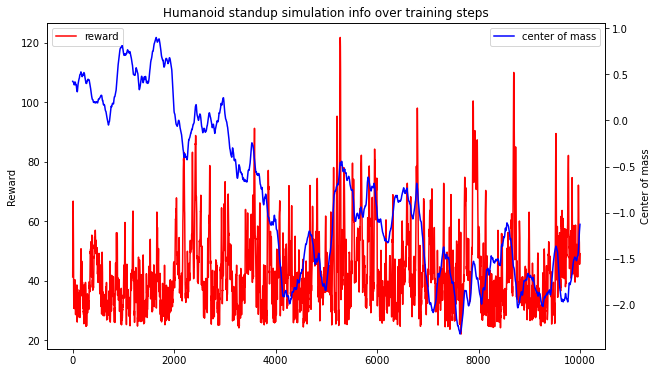

In [127]:
df = load_results(log_dir_humanoid)

rewards = df['r']
rewards_per_step = []

sub_rewards = df['sub_r']
sub_rewards_per_step = []
for i in range(1,len(rewards)):
    rewards_per_step.append(rewards[i]-rewards[i-1])
    sub_rewards_per_step.append(sub_rewards[i]-sub_rewards[i-1])

    
    
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(rewards_per_step, color = 'red', label='reward')
ax.set_ylabel("Reward")

ax2 = ax.twinx()
ax2.plot(sub_rewards_per_step, color='blue', label='center of mass')
ax2.set_ylabel('Center of mass')

ax.legend(loc = 'upper left')
ax2.legend(loc = 'upper right')
plt.title('Humanoid standup simulation info over training steps')
plt.show()

# reward here should be the vertical velocity/position? of the abdomen
# minus some control and impact cost


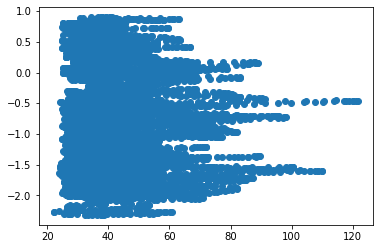

In [130]:
plt.scatter(rewards_per_step, sub_rewards_per_step)

In [134]:
env2.sim.data.ctrl

array([-0.4       , -0.4       ,  0.4       , -0.4       , -0.03027134,
        0.4       ,  0.4       ,  0.25392199, -0.03093702, -0.4       ,
       -0.17598316, -0.4       ,  0.30606344,  0.4       ,  0.4       ,
       -0.4       , -0.4       ])

In [136]:
env2.sim.data.cfrc_ext

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

36.21917881409192
34.5223464153393
{'reward_linup': 33.61861271373162, 'reward_quadctrl': -0.09626629839232177, 'reward_impact': -0.0, 'subtask_1': 0.42539257822186854}
36.930371642079926
{'reward_linup': 36.013924302146926, 'reward_quadctrl': -0.08355266006699608, 'reward_impact': -0.0, 'subtask_1': 0.4220353493236128}
38.34978384647489
{'reward_linup': 37.41888931898062, 'reward_quadctrl': -0.06910547250572435, 'reward_impact': -0.0, 'subtask_1': 0.4185158603152579}
38.57092911988894
{'reward_linup': 37.635471209273895, 'reward_quadctrl': -0.06454208938495869, 'reward_impact': -0.0, 'subtask_1': 0.41505046377192156}
37.69548413047233
{'reward_linup': 36.77660020752204, 'reward_quadctrl': -0.0811160770497094, 'reward_impact': -0.0, 'subtask_1': 0.4120057947548688}
36.48472527860208
{'reward_linup': 35.561808415073635, 'reward_quadctrl': -0.07708313647155746, 'reward_impact': -0.0, 'subtask_1': 0.40983988176886005}
34.65472224183838
{'reward_linup': 33.73915554903779, 'reward_quadctrl'

39.68995159625046
{'reward_linup': 38.79771594831741, 'reward_quadctrl': -0.10776435206695348, 'reward_impact': -0.0, 'subtask_1': 0.5762792388540638}
40.07001483612897
{'reward_linup': 39.15511639795251, 'reward_quadctrl': -0.08510156182354207, 'reward_impact': -0.0, 'subtask_1': 0.5768253466580784}
41.09432881011647
{'reward_linup': 40.190672215406636, 'reward_quadctrl': -0.09634340529016255, 'reward_impact': -0.0, 'subtask_1': 0.5766278363094651}
42.18790817217236
{'reward_linup': 41.27262909922533, 'reward_quadctrl': -0.08472092705296813, 'reward_impact': -0.0, 'subtask_1': 0.5763564017902466}
43.97900236350654
{'reward_linup': 43.09294228792825, 'reward_quadctrl': -0.1139399244217148, 'reward_impact': -0.0, 'subtask_1': 0.5772205155590122}
45.35457429340277
{'reward_linup': 44.4311795385114, 'reward_quadctrl': -0.0766052451086299, 'reward_impact': -0.0, 'subtask_1': 0.5787861053942301}
46.11178978507559
{'reward_linup': 45.21060755534058, 'reward_quadctrl': -0.09881777026499697, '

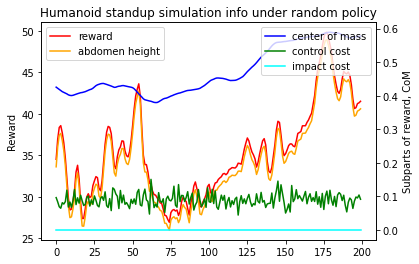

In [140]:
env = HumanoidStandupEnv()
rewards = []
sub_rewards = []

z_reward = []
control_cost = []
impact_cost = []

env.reset_model()
for t in range(200):
    #Takes a random action from its action space 
    observation, reward, done, info = env.step(env.action_space.sample())
    #print(observation)
    print(info)
    rewards.append(reward)
    sub_rewards.append(info['subtask_1'])
    z_reward.append(info['reward_linup'])
    control_cost.append(-info['reward_quadctrl'])
    impact_cost.append(-info['reward_impact'])
    
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
env.close()

fig, ax = plt.subplots()
ax.plot(rewards, color = 'red', label='reward')
ax.plot(z_reward, color = 'orange', label='abdomen height')
ax.set_ylabel("Reward")

ax2 = ax.twinx()
ax2.plot(sub_rewards, color='blue', label='center of mass')
ax2.plot(control_cost, color = 'green', label = 'control cost')
ax2.plot(impact_cost, color = 'cyan', label = 'impact cost')
ax2.set_ylabel('Subparts of reward, CoM')

ax.legend(loc = 'upper left')
ax2.legend(loc = 'upper right')
plt.title('Humanoid standup simulation info under random policy')
plt.show()



Text(0.5, 1.0, 'Center of mass of humanoid over time steps')

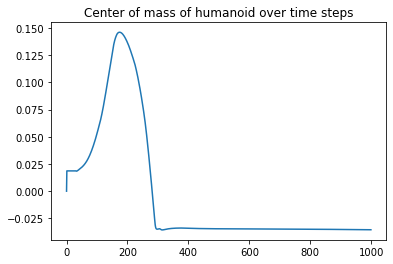

In [218]:
mj_path, _ = mujoco_py.utils.discover_mujoco()
xml_path = os.path.join(mj_path, 'model', 'humanoid.xml')
model = mujoco_py.load_model_from_path(xml_path)
sim = mujoco_py.MjSim(model)

state_vars = ['qpos', 'qvel', 'cinert', 'cvel', 'qfrc_actuator', 'cfrc_ext']

#for i in range(len(state_vars)):
    #state_var = eval('sim.data.'+state_vars[i])
    #print(len(state_var))

    
    
n_steps = 1000

CoM_record = []

for _ in range(n_steps):
    
    #print(mass_center(model, sim))
    CoM_record.append(mass_center(model, sim))    
    #for i in range(len(state_vars)):
        #print(state_vars[i], eval('sim.data.'+state_vars[i]))
        
        
    sim.step()

plt.plot(CoM_record)
plt.title('Center of mass of humanoid over time steps')

In [ ]:
evaluate_policy(model, eval_env, return_episode_rewards=True)

import warnings
from typing import Any, Callable, Dict, List, Optional, Tuple, Union



from stable_baselines3.common import base_class
#from stable_baselines3.common.vec_env import VecEnv, VecMonitor, is_vecenv_wrapped


def evaluate_policy(
    model: "base_class.BaseAlgorithm",
    env: Union[gym.Env, VecEnv],
    n_eval_episodes: int = 10,
    deterministic: bool = True,
    render: bool = False,
    callback: Optional[Callable[[Dict[str, Any], Dict[str, Any]], None]] = None,
    reward_threshold: Optional[float] = None,
    return_episode_rewards: bool = False,
    warn: bool = True,
) -> Union[Tuple[float, float], Tuple[List[float], List[int]]]:
    """
    Runs policy for ``n_eval_episodes`` episodes and returns average reward.
    This is made to work only with one env.

    .. note::
        If environment has not been wrapped with ``Monitor`` wrapper, reward and
        episode lengths are counted as it appears with ``env.step`` calls. If
        the environment contains wrappers that modify rewards or episode lengths
        (e.g. reward scaling, early episode reset), these will affect the evaluation
        results as well. You can avoid this by wrapping environment with ``Monitor``
        wrapper before anything else.

    :param model: The RL agent you want to evaluate.
    :param env: The gym environment. In the case of a ``VecEnv``
        this must contain only one environment.
    :param n_eval_episodes: Number of episode to evaluate the agent
    :param deterministic: Whether to use deterministic or stochastic actions
    :param render: Whether to render the environment or not
    :param callback: callback function to do additional checks,
        called after each step. Gets locals() and globals() passed as parameters.
    :param reward_threshold: Minimum expected reward per episode,
        this will raise an error if the performance is not met
    :param return_episode_rewards: If True, a list of rewards and episode lengths
        per episode will be returned instead of the mean.
    :param warn: If True (default), warns user about lack of a Monitor wrapper in the
        evaluation environment.
    :return: Mean reward per episode, std of reward per episode.
        Returns ([float], [int]) when ``return_episode_rewards`` is True, first
        list containing per-episode rewards and second containing per-episode lengths
        (in number of steps).
    """
    is_monitor_wrapped = False
    # Avoid circular import
    from stable_baselines3.common.env_util import is_wrapped
    from stable_baselines3.common.monitor import Monitor

    if isinstance(env, VecEnv):
        assert env.num_envs == 1, "You must pass only one environment when using this function"
        is_monitor_wrapped = is_vecenv_wrapped(env, VecMonitor) or env.env_is_wrapped(Monitor)[0]
    else:
        is_monitor_wrapped = is_wrapped(env, Monitor)

    if not is_monitor_wrapped and warn:
        warnings.warn(
            "Evaluation environment is not wrapped with a ``Monitor`` wrapper. "
            "This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. "
            "Consider wrapping environment first with ``Monitor`` wrapper.",
            UserWarning,
        )

    episode_rewards, episode_lengths, episode_subtask_rewards = [], [], []
    not_reseted = True
    while len(episode_rewards) < n_eval_episodes:
        # Number of loops here might differ from true episodes
        # played, if underlying wrappers modify episode lengths.
        # Avoid double reset, as VecEnv are reset automatically.
        if not isinstance(env, VecEnv) or not_reseted:
            obs = env.reset()
            not_reseted = False
        done, state = False, None
        episode_reward = 0.0
        episode_length = 0
        subtask_reward = 0
        while not done:
            action, state = model.predict(obs, state=state, deterministic=deterministic)
            obs, reward, done, info = env.step(action)
            episode_reward += reward
            subtask_reward += list(info.values())[0]
            if callback is not None:
                callback(locals(), globals())
            episode_length += 1
            if render:
                env.render()

        if is_monitor_wrapped:
            # Do not trust "done" with episode endings.
            # Remove vecenv stacking (if any)
            if isinstance(env, VecEnv):
                info = info[0]
            if "episode" in info.keys():
                # Monitor wrapper includes "episode" key in info if environment
                # has been wrapped with it. Use those rewards instead.
                episode_rewards.append(info["episode"]["r"])
                episode_lengths.append(info["episode"]["l"])
        else:
            episode_rewards.append(episode_reward)
            episode_lengths.append(episode_length)
            episode_subtask_rewards.append(subtask_reward)

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    if reward_threshold is not None:
        assert mean_reward > reward_threshold, "Mean reward below threshold: " f"{mean_reward:.2f} < {reward_threshold:.2f}"
    if return_episode_rewards:
        return episode_rewards, episode_lengths, episode_subtask_rewards
    
    return mean_reward, std_reward


In [34]:
env1 = CartPoleEnv()

n_episodes = 20


subtask_records = [None] * n_episodes

for i_episode in range(n_episodes):
    observation = env1.reset()
    subtask_performance = []
    for t in range(100):
        #env1.render()
        #print(observation)
        action = env1.action_space.sample()
        observation, reward, done, info = env1.step(action)
        subtask_performance.append(info['subtask_1'])
        if done:
            #print("Episode finished after {} timesteps".format(t+1))
            break
    subtask_records[i_episode] = subtask_performance
env1.close()
print(subtask_records)

[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 

In [90]:
# below is me learning to use pickle

import pickle

filename = 'pickled_theta_records'

outfile = open(filename,'wb')

pickle.dump(theta_records, outfile)
outfile.close()

In [93]:
infile = open(filename,'rb')
theta_records_unpickled = pickle.load(infile)
infile.close()

10

In [3]:
import os
mj_path, _ = mujoco_py.utils.discover_mujoco()
xml_path = os.path.join(mj_path, 'model', 'humanoid.xml')
model = mujoco_py.load_model_from_path(xml_path)
sim = mujoco_py.MjSim(model)

In [4]:
sim.step()
print(sim.data.qpos)
# [-2.09531783e-19  2.72130735e-05  6.14480786e-22 -3.45474715e-06
#   7.42993721e-06 -1.40711141e-04 -3.04253586e-04 -2.07559344e-04
#   8.50646247e-05 -3.45474715e-06  7.42993721e-06 -1.40711141e-04
#  -3.04253586e-04 -2.07559344e-04 -8.50646247e-05  1.11317030e-04
#  -7.03465386e-05 -2.22862221e-05 -1.11317030e-04  7.03465386e-05
#  -2.22862221e-05]

[-1.12164337e-05  7.29847036e-22  1.39975300e+00  9.99999999e-01
  1.80085466e-21  4.45933954e-05 -2.70143345e-20  1.30126513e-19
 -4.63561234e-05 -1.88020744e-20 -2.24492958e-06  4.79357124e-05
 -6.38208396e-04 -1.61130312e-03 -1.37554006e-03  5.54173825e-05
 -2.24492958e-06  4.79357124e-05 -6.38208396e-04 -1.61130312e-03
 -1.37554006e-03 -5.54173825e-05 -5.73572648e-05  7.63833991e-05
 -2.12765194e-05  5.73572648e-05 -7.63833991e-05 -2.12765194e-05]
